In [22]:
import strawberryfields as sf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# --- CONFIGURATION ---
sf.hbar = 1
np.random.seed(42)

# Parameters

eta, delta = 0.9, 0.01
num_steps = 200
learning_rate = 0.0005  
quad_pts = 200
quad_axis = np.linspace(-6, 6, quad_pts)


# --- Helper Functions ---
def db_to_epsilon(db_val: float) -> float:
    """
    Convert a given GKP squeezing level in dB to epsilon via:
         tanh(epsilon) = 10^(-db_val/10)
    """
    t = 10.0 ** (-db_val / 10.0)
    eps = 0.5 * np.log((1.0 + t) / (1.0 - t))
    return eps

def prepare_gkp_state(epsilon, eta, gamma, phi=0.0, Nphi=15, phi_clip=3.0):
    """
    Prepare GKP state under loss (eta) and approximate dephasing (gamma),
    returning its 2D Wigner function on the grid 'quad_axis'.
    """
    prog = sf.Program(1)
    eng = sf.Engine("bosonic")

    phi_std = np.sqrt(gamma)
    if gamma < 1e-12:
        with prog.context as q:
            sf.ops.GKP(state=[0,0], epsilon=epsilon) | q[0]
            if eta < 1.0:
                sf.ops.LossChannel(eta) | q[0]
            sf.ops.Rgate(phi) | q[0]
        state = eng.run(prog).state
        W = state.wigner(0, quad_axis, quad_axis)
        return W

    # Otherwise, approximate dephasing by averaging over random rotations
    phis = np.linspace(-phi_clip*phi_std, phi_clip*phi_std, Nphi)
    dphi = phis[1] - phis[0]
    weights = np.exp(-0.5*(phis/phi_std)**2)
    weights /= weights.sum()

    wigner_avg = np.zeros((quad_pts, quad_pts), dtype=float)
    for phi_val, w in zip(phis, weights):
        prog = sf.Program(1)
        with prog.context as q:
            sf.ops.GKP(state=[0,0], epsilon=epsilon) | q[0]
            sf.ops.LossChannel(eta) | q[0]
            sf.ops.Rgate(phi_val) | q[0]
        state = eng.run(prog).state
        wigner_avg += w * state.wigner(0, quad_axis, quad_axis)

    return wigner_avg


def marginal_from_wigner(W, xvec, phi):
    """
    Numerically compute the marginal distribution P(x_mu).
    = ∫ W(q,p) delta[x_mu - (q*cos(phi)+p*sin(phi))] dq dp.

    'Bin and accumulate' approach:
      - rotate each (q,p) -> x_mu
      - bin into xvec
      - sum W(q,p)*dq*dp
      - normalize
    """
    Q, P = np.meshgrid(xvec, xvec, indexing='xy')
    dq = xvec[1] - xvec[0]
    dp = dq

    X = Q * np.cos(phi) + P * np.sin(phi)

    P_x = np.zeros_like(xvec, dtype=float)
    for i in range(len(xvec)):
        for j in range(len(xvec)):
            xval = X[i,j]
            idx = int(np.floor((xval - xvec[0]) / dq))
            if 0 <= idx < len(xvec):
                P_x[idx] += W[i,j] * dq * dp

    # Normalize
    norm = np.trapz(P_x, xvec)
    if norm > 1e-15:
        P_x /= norm
    return P_x

def classical_fisher(mu, epsilon, eta, delta, d_eta=1e-3, d_delta=1e-3):
    """
    Calculate the 2x2 classical Fisher information matrix w.r.t. (eta, delta),
    given the homodyne measurement of quadrature x_mu.
    """
    # Base Wigner
    W_base = prepare_gkp_state(epsilon, eta, delta)
    P_mu = marginal_from_wigner(W_base, quad_axis, mu) + 1e-12

    # dP/d_eta
    W_eta_plus = prepare_gkp_state(epsilon, eta + d_eta, delta)
    P_eta_plus = marginal_from_wigner(W_eta_plus, quad_axis, mu) + 1e-12
    dP_eta = (P_eta_plus - P_mu) / d_eta

    # dP/d_delta
    W_delta_plus = prepare_gkp_state(epsilon, eta, delta + d_delta)
    P_delta_plus = marginal_from_wigner(W_delta_plus, quad_axis, mu) + 1e-12
    dP_delta = (P_delta_plus - P_mu) / d_delta

    # Fisher matrix
    F_eta_eta = np.trapz((dP_eta**2) / P_mu, quad_axis)
    F_delta_delta = np.trapz((dP_delta**2) / P_mu, quad_axis)
    F_eta_delta = np.trapz((dP_eta * dP_delta) / P_mu, quad_axis)

    return np.array([[F_eta_eta, F_eta_delta],
                     [F_eta_delta, F_delta_delta]])

def fisher_det_mu(mu, epsilon, eta, delta):
    """To return det(F) for given mu."""
    F = classical_fisher(mu, epsilon, eta, delta)
    return np.linalg.det(F)


### CFI 10 Db

In [23]:
db = 10
epsilon = db_to_epsilon(db)  
mu = 2.3592999716910443
print(f"Initial mu: {mu:.4f}")

fisher_history, mu_history = [], []
momentum = 0.9
velocity = 0

for step in tqdm(range(num_steps)):
    # Evaluate F and its determinant at current mu
    F = classical_fisher(mu, epsilon, eta, delta)
    det_F = np.linalg.det(F)

    # Central difference for derivative wrt mu
    delta_mu = 1e-3
    det_F_minus = fisher_det_mu(mu - delta_mu, epsilon, eta, delta)
    det_F_plus  = fisher_det_mu(mu + delta_mu, epsilon, eta, delta)
    grad_mu = (det_F_plus - det_F_minus) / (2 * delta_mu)

    # Clip gradient
    grad_mu = np.clip(grad_mu, -0.01, 0.01)

    # Momentum-based gradient ascent update
    velocity = 0.9 * velocity + learning_rate * grad_mu
    mu += velocity
    mu %= (2 * np.pi)

    # # Gradient ascent step
    # mu += learning_rate * grad_mu
    # mu = mu % (2 * np.pi)

    fisher_history.append(det_F)
    mu_history.append(mu)

    if step % 1 == 0:
        print(f"Step {step}: mu={mu:.4f}, Fisher={det_F:.4e}")

Initial mu: 2.3593


  0%|          | 1/200 [01:50<6:07:42, 110.87s/it]

Step 0: mu=2.3593, Fisher=3.5375e+02


  1%|          | 2/200 [03:41<6:04:33, 110.47s/it]

Step 1: mu=2.3593, Fisher=3.5376e+02


  2%|▏         | 3/200 [05:31<6:03:11, 110.61s/it]

Step 2: mu=2.3593, Fisher=3.5391e+02


  2%|▏         | 4/200 [07:22<6:01:45, 110.74s/it]

Step 3: mu=2.3593, Fisher=3.5375e+02


  2%|▎         | 5/200 [09:11<5:57:42, 110.07s/it]

Step 4: mu=2.3594, Fisher=3.5444e+02


  3%|▎         | 6/200 [11:01<5:55:13, 109.86s/it]

Step 5: mu=2.3594, Fisher=3.5562e+02


  4%|▎         | 7/200 [12:50<5:53:05, 109.77s/it]

Step 6: mu=2.3594, Fisher=3.5531e+02


  4%|▍         | 8/200 [14:39<5:50:32, 109.54s/it]

Step 7: mu=2.3594, Fisher=3.5523e+02


  4%|▍         | 9/200 [16:28<5:48:13, 109.39s/it]

Step 8: mu=2.3595, Fisher=3.5637e+02


  5%|▌         | 10/200 [18:17<5:45:52, 109.23s/it]

Step 9: mu=2.3595, Fisher=3.5728e+02


  6%|▌         | 11/200 [20:07<5:44:17, 109.30s/it]

Step 10: mu=2.3595, Fisher=3.5815e+02


  6%|▌         | 12/200 [21:55<5:41:40, 109.04s/it]

Step 11: mu=2.3596, Fisher=3.5790e+02


  6%|▋         | 13/200 [23:44<5:39:36, 108.97s/it]

Step 12: mu=2.3596, Fisher=3.5937e+02


  7%|▋         | 14/200 [25:33<5:37:58, 109.02s/it]

Step 13: mu=2.3597, Fisher=3.5929e+02


  8%|▊         | 15/200 [27:22<5:35:53, 108.94s/it]

Step 14: mu=2.3597, Fisher=3.5981e+02


  8%|▊         | 16/200 [29:11<5:34:07, 108.95s/it]

Step 15: mu=2.3597, Fisher=3.6123e+02


  8%|▊         | 17/200 [31:00<5:32:37, 109.06s/it]

Step 16: mu=2.3598, Fisher=3.6171e+02


  9%|▉         | 18/200 [32:49<5:30:31, 108.96s/it]

Step 17: mu=2.3598, Fisher=3.6266e+02


 10%|▉         | 19/200 [34:38<5:28:36, 108.93s/it]

Step 18: mu=2.3599, Fisher=3.6327e+02


 10%|█         | 20/200 [36:27<5:26:58, 108.99s/it]

Step 19: mu=2.3599, Fisher=3.6553e+02


 10%|█         | 21/200 [38:16<5:25:12, 109.01s/it]

Step 20: mu=2.3599, Fisher=3.6624e+02


 11%|█         | 22/200 [40:05<5:23:09, 108.93s/it]

Step 21: mu=2.3600, Fisher=3.6640e+02


 12%|█▏        | 23/200 [41:53<5:21:09, 108.87s/it]

Step 22: mu=2.3600, Fisher=3.6736e+02


 12%|█▏        | 24/200 [43:42<5:19:15, 108.84s/it]

Step 23: mu=2.3601, Fisher=3.6935e+02


 12%|█▎        | 25/200 [45:32<5:18:35, 109.23s/it]

Step 24: mu=2.3601, Fisher=3.7043e+02


 13%|█▎        | 26/200 [47:25<5:19:29, 110.17s/it]

Step 25: mu=2.3602, Fisher=3.7112e+02


 14%|█▎        | 27/200 [49:15<5:18:15, 110.38s/it]

Step 26: mu=2.3602, Fisher=3.7415e+02


 14%|█▍        | 28/200 [51:06<5:16:36, 110.45s/it]

Step 27: mu=2.3603, Fisher=3.7419e+02


 14%|█▍        | 29/200 [52:58<5:15:46, 110.80s/it]

Step 28: mu=2.3603, Fisher=3.7733e+02


 15%|█▌        | 30/200 [54:49<5:14:03, 110.84s/it]

Step 29: mu=2.3604, Fisher=3.7795e+02


 16%|█▌        | 31/200 [56:40<5:12:56, 111.10s/it]

Step 30: mu=2.3604, Fisher=3.7796e+02


 16%|█▌        | 32/200 [58:31<5:11:03, 111.09s/it]

Step 31: mu=2.3605, Fisher=3.8101e+02


 16%|█▋        | 33/200 [1:00:23<5:09:12, 111.10s/it]

Step 32: mu=2.3605, Fisher=3.8129e+02


 17%|█▋        | 34/200 [1:02:14<5:07:32, 111.16s/it]

Step 33: mu=2.3606, Fisher=3.8431e+02


 18%|█▊        | 35/200 [1:04:05<5:05:33, 111.11s/it]

Step 34: mu=2.3606, Fisher=3.8460e+02


 18%|█▊        | 36/200 [1:05:55<5:03:14, 110.94s/it]

Step 35: mu=2.3607, Fisher=3.8565e+02


 18%|█▊        | 37/200 [1:07:46<5:00:59, 110.80s/it]

Step 36: mu=2.3607, Fisher=3.8772e+02


 19%|█▉        | 38/200 [1:09:36<4:58:46, 110.66s/it]

Step 37: mu=2.3608, Fisher=3.8878e+02


 20%|█▉        | 39/200 [1:11:27<4:57:01, 110.69s/it]

Step 38: mu=2.3608, Fisher=3.9133e+02


 20%|██        | 40/200 [1:13:18<4:55:20, 110.75s/it]

Step 39: mu=2.3609, Fisher=3.9351e+02


 20%|██        | 41/200 [1:15:08<4:53:17, 110.68s/it]

Step 40: mu=2.3609, Fisher=3.9448e+02


 21%|██        | 42/200 [1:16:58<4:50:30, 110.32s/it]

Step 41: mu=2.3610, Fisher=3.9616e+02


 22%|██▏       | 43/200 [1:18:47<4:47:37, 109.92s/it]

Step 42: mu=2.3610, Fisher=3.9654e+02


 22%|██▏       | 44/200 [1:20:36<4:45:30, 109.81s/it]

Step 43: mu=2.3611, Fisher=3.9557e+02


 22%|██▎       | 45/200 [1:22:26<4:43:27, 109.73s/it]

Step 44: mu=2.3611, Fisher=3.9901e+02


 23%|██▎       | 46/200 [1:24:15<4:41:19, 109.61s/it]

Step 45: mu=2.3612, Fisher=3.9924e+02


 24%|██▎       | 47/200 [1:26:05<4:39:33, 109.63s/it]

Step 46: mu=2.3612, Fisher=4.0348e+02


 24%|██▍       | 48/200 [1:27:54<4:37:30, 109.54s/it]

Step 47: mu=2.3613, Fisher=4.0387e+02


 24%|██▍       | 49/200 [1:29:43<4:35:07, 109.32s/it]

Step 48: mu=2.3613, Fisher=4.0518e+02


 25%|██▌       | 50/200 [1:31:32<4:33:21, 109.35s/it]

Step 49: mu=2.3614, Fisher=4.0825e+02


 26%|██▌       | 51/200 [1:33:22<4:32:00, 109.53s/it]

Step 50: mu=2.3614, Fisher=4.0826e+02


 26%|██▌       | 52/200 [1:35:12<4:30:18, 109.58s/it]

Step 51: mu=2.3615, Fisher=4.0903e+02


 26%|██▋       | 53/200 [1:37:02<4:28:58, 109.79s/it]

Step 52: mu=2.3615, Fisher=4.1242e+02


 27%|██▋       | 54/200 [1:38:52<4:27:23, 109.89s/it]

Step 53: mu=2.3616, Fisher=4.1667e+02


 28%|██▊       | 55/200 [1:40:43<4:25:45, 109.97s/it]

Step 54: mu=2.3616, Fisher=4.1804e+02


 28%|██▊       | 56/200 [1:42:33<4:23:54, 109.96s/it]

Step 55: mu=2.3617, Fisher=4.2158e+02


 28%|██▊       | 57/200 [1:44:22<4:21:51, 109.87s/it]

Step 56: mu=2.3617, Fisher=4.2384e+02


 29%|██▉       | 58/200 [1:46:12<4:20:06, 109.90s/it]

Step 57: mu=2.3618, Fisher=4.3100e+02


 30%|██▉       | 59/200 [1:48:02<4:18:14, 109.89s/it]

Step 58: mu=2.3618, Fisher=4.3585e+02


 30%|███       | 60/200 [1:49:52<4:16:23, 109.88s/it]

Step 59: mu=2.3619, Fisher=4.3191e+02


 30%|███       | 61/200 [1:51:42<4:14:49, 110.00s/it]

Step 60: mu=2.3619, Fisher=4.3633e+02


 31%|███       | 62/200 [1:53:32<4:13:05, 110.04s/it]

Step 61: mu=2.3620, Fisher=4.3965e+02


 32%|███▏      | 63/200 [1:55:21<4:10:09, 109.56s/it]

Step 62: mu=2.3620, Fisher=4.5204e+02


 32%|███▏      | 64/200 [1:57:11<4:08:33, 109.66s/it]

Step 63: mu=2.3621, Fisher=4.5122e+02


 32%|███▎      | 65/200 [1:59:01<4:07:04, 109.81s/it]

Step 64: mu=2.3621, Fisher=4.5552e+02


 33%|███▎      | 66/200 [2:00:51<4:05:20, 109.85s/it]

Step 65: mu=2.3622, Fisher=4.6337e+02


 34%|███▎      | 67/200 [2:02:41<4:03:30, 109.85s/it]

Step 66: mu=2.3622, Fisher=4.6467e+02


 34%|███▍      | 68/200 [2:04:31<4:01:55, 109.96s/it]

Step 67: mu=2.3623, Fisher=4.6830e+02


 34%|███▍      | 69/200 [2:06:21<3:59:56, 109.90s/it]

Step 68: mu=2.3623, Fisher=4.8021e+02


 35%|███▌      | 70/200 [2:08:09<3:57:21, 109.55s/it]

Step 69: mu=2.3624, Fisher=4.8455e+02


 36%|███▌      | 71/200 [2:09:58<3:54:48, 109.22s/it]

Step 70: mu=2.3624, Fisher=4.9180e+02


 36%|███▌      | 72/200 [2:11:46<3:52:28, 108.97s/it]

Step 71: mu=2.3625, Fisher=4.9728e+02


 36%|███▋      | 73/200 [2:13:34<3:50:06, 108.72s/it]

Step 72: mu=2.3625, Fisher=5.0264e+02


 37%|███▋      | 74/200 [2:15:23<3:48:06, 108.62s/it]

Step 73: mu=2.3626, Fisher=5.0811e+02


 38%|███▊      | 75/200 [2:17:11<3:46:06, 108.54s/it]

Step 74: mu=2.3626, Fisher=5.1712e+02


 38%|███▊      | 76/200 [2:19:00<3:44:19, 108.55s/it]

Step 75: mu=2.3627, Fisher=5.1919e+02


 38%|███▊      | 77/200 [2:20:49<3:43:03, 108.81s/it]

Step 76: mu=2.3627, Fisher=5.3054e+02


 39%|███▉      | 78/200 [2:22:38<3:41:24, 108.89s/it]

Step 77: mu=2.3628, Fisher=5.3499e+02


 40%|███▉      | 79/200 [2:24:26<3:39:07, 108.66s/it]

Step 78: mu=2.3628, Fisher=5.4291e+02


 40%|████      | 80/200 [2:26:14<3:36:59, 108.50s/it]

Step 79: mu=2.3629, Fisher=5.5129e+02


 40%|████      | 81/200 [2:28:03<3:35:12, 108.51s/it]

Step 80: mu=2.3629, Fisher=5.5524e+02


 41%|████      | 82/200 [2:29:51<3:33:12, 108.41s/it]

Step 81: mu=2.3630, Fisher=5.6650e+02


 42%|████▏     | 83/200 [2:31:40<3:31:27, 108.44s/it]

Step 82: mu=2.3630, Fisher=5.6336e+02


 42%|████▏     | 84/200 [2:33:28<3:29:42, 108.47s/it]

Step 83: mu=2.3631, Fisher=5.7813e+02


 42%|████▎     | 85/200 [2:35:17<3:27:54, 108.48s/it]

Step 84: mu=2.3631, Fisher=5.8780e+02


 43%|████▎     | 86/200 [2:37:05<3:25:59, 108.42s/it]

Step 85: mu=2.3632, Fisher=5.9198e+02


 44%|████▎     | 87/200 [2:38:53<3:24:04, 108.36s/it]

Step 86: mu=2.3632, Fisher=5.9176e+02


 44%|████▍     | 88/200 [2:40:41<3:22:12, 108.33s/it]

Step 87: mu=2.3633, Fisher=5.9454e+02


 44%|████▍     | 89/200 [2:42:30<3:20:32, 108.40s/it]

Step 88: mu=2.3633, Fisher=5.9664e+02


 45%|████▌     | 90/200 [2:44:19<3:18:51, 108.47s/it]

Step 89: mu=2.3634, Fisher=6.0667e+02


 46%|████▌     | 91/200 [2:46:08<3:17:20, 108.63s/it]

Step 90: mu=2.3634, Fisher=6.1827e+02


 46%|████▌     | 92/200 [2:47:56<3:15:39, 108.70s/it]

Step 91: mu=2.3634, Fisher=6.2681e+02


 46%|████▋     | 93/200 [2:49:45<3:13:39, 108.59s/it]

Step 92: mu=2.3635, Fisher=6.3163e+02


 47%|████▋     | 94/200 [2:51:33<3:11:40, 108.49s/it]

Step 93: mu=2.3635, Fisher=6.3663e+02


 48%|████▊     | 95/200 [2:53:21<3:09:49, 108.47s/it]

Step 94: mu=2.3636, Fisher=6.3904e+02


 48%|████▊     | 96/200 [2:55:10<3:08:13, 108.59s/it]

Step 95: mu=2.3636, Fisher=6.4229e+02


 48%|████▊     | 97/200 [2:56:59<3:06:20, 108.55s/it]

Step 96: mu=2.3637, Fisher=6.4597e+02


 49%|████▉     | 98/200 [2:58:48<3:04:39, 108.62s/it]

Step 97: mu=2.3637, Fisher=6.4002e+02


 50%|████▉     | 99/200 [3:00:36<3:02:53, 108.64s/it]

Step 98: mu=2.3638, Fisher=6.5524e+02


 50%|█████     | 100/200 [3:02:25<3:01:05, 108.65s/it]

Step 99: mu=2.3638, Fisher=6.6221e+02


 50%|█████     | 101/200 [3:04:14<2:59:20, 108.69s/it]

Step 100: mu=2.3639, Fisher=6.6376e+02


 51%|█████     | 102/200 [3:06:02<2:57:18, 108.56s/it]

Step 101: mu=2.3639, Fisher=6.6106e+02


 52%|█████▏    | 103/200 [3:07:50<2:55:27, 108.53s/it]

Step 102: mu=2.3640, Fisher=6.7270e+02


 52%|█████▏    | 104/200 [3:09:39<2:53:34, 108.49s/it]

Step 103: mu=2.3640, Fisher=6.7348e+02


 52%|█████▎    | 105/200 [3:11:28<2:52:06, 108.70s/it]

Step 104: mu=2.3641, Fisher=6.7515e+02


 53%|█████▎    | 106/200 [3:13:18<2:50:41, 108.95s/it]

Step 105: mu=2.3641, Fisher=6.8057e+02


 54%|█████▎    | 107/200 [3:15:07<2:49:15, 109.20s/it]

Step 106: mu=2.3642, Fisher=6.8669e+02


 54%|█████▍    | 108/200 [3:16:57<2:47:50, 109.46s/it]

Step 107: mu=2.3642, Fisher=7.0321e+02


 55%|█████▍    | 109/200 [3:18:47<2:46:06, 109.52s/it]

Step 108: mu=2.3643, Fisher=7.0647e+02


 55%|█████▌    | 110/200 [3:20:37<2:44:17, 109.53s/it]

Step 109: mu=2.3643, Fisher=7.0790e+02


 56%|█████▌    | 111/200 [3:22:26<2:42:36, 109.62s/it]

Step 110: mu=2.3644, Fisher=7.1189e+02


 56%|█████▌    | 112/200 [3:24:16<2:40:34, 109.49s/it]

Step 111: mu=2.3644, Fisher=7.2390e+02


 56%|█████▋    | 113/200 [3:26:05<2:38:45, 109.49s/it]

Step 112: mu=2.3645, Fisher=7.2753e+02


 57%|█████▋    | 114/200 [3:27:55<2:37:01, 109.56s/it]

Step 113: mu=2.3645, Fisher=7.2309e+02


 57%|█████▊    | 115/200 [3:29:44<2:35:12, 109.56s/it]

Step 114: mu=2.3646, Fisher=7.1906e+02


 58%|█████▊    | 116/200 [3:31:34<2:33:23, 109.57s/it]

Step 115: mu=2.3646, Fisher=7.1814e+02


 58%|█████▊    | 117/200 [3:33:24<2:31:37, 109.60s/it]

Step 116: mu=2.3647, Fisher=7.2471e+02


 59%|█████▉    | 118/200 [3:35:14<2:29:59, 109.75s/it]

Step 117: mu=2.3647, Fisher=7.3470e+02


 60%|█████▉    | 119/200 [3:37:04<2:28:10, 109.76s/it]

Step 118: mu=2.3648, Fisher=7.3684e+02


 60%|██████    | 120/200 [3:38:54<2:26:33, 109.92s/it]

Step 119: mu=2.3648, Fisher=7.3771e+02


 60%|██████    | 121/200 [3:40:44<2:24:48, 109.98s/it]

Step 120: mu=2.3649, Fisher=7.4013e+02


 61%|██████    | 122/200 [3:42:35<2:23:12, 110.16s/it]

Step 121: mu=2.3649, Fisher=7.4393e+02


 62%|██████▏   | 123/200 [3:44:25<2:21:31, 110.28s/it]

Step 122: mu=2.3650, Fisher=7.4166e+02


 62%|██████▏   | 124/200 [3:46:15<2:19:43, 110.31s/it]

Step 123: mu=2.3650, Fisher=7.4319e+02


 62%|██████▎   | 125/200 [3:48:06<2:17:57, 110.37s/it]

Step 124: mu=2.3651, Fisher=7.4084e+02


 63%|██████▎   | 126/200 [3:49:57<2:16:15, 110.48s/it]

Step 125: mu=2.3651, Fisher=7.4599e+02


 64%|██████▎   | 127/200 [3:51:47<2:14:10, 110.27s/it]

Step 126: mu=2.3651, Fisher=7.4580e+02


 64%|██████▍   | 128/200 [3:53:37<2:12:15, 110.22s/it]

Step 127: mu=2.3651, Fisher=7.4908e+02


 64%|██████▍   | 129/200 [3:55:27<2:10:31, 110.30s/it]

Step 128: mu=2.3651, Fisher=7.4903e+02


 65%|██████▌   | 130/200 [3:57:17<2:08:41, 110.30s/it]

Step 129: mu=2.3651, Fisher=7.5059e+02


 66%|██████▌   | 131/200 [3:59:07<2:06:46, 110.24s/it]

Step 130: mu=2.3651, Fisher=7.4920e+02


 66%|██████▌   | 132/200 [4:00:58<2:05:02, 110.34s/it]

Step 131: mu=2.3651, Fisher=7.4890e+02


 66%|██████▋   | 133/200 [4:02:47<2:02:52, 110.04s/it]

Step 132: mu=2.3651, Fisher=7.4609e+02


 67%|██████▋   | 134/200 [4:04:35<2:00:19, 109.38s/it]

Step 133: mu=2.3651, Fisher=7.4581e+02


 68%|██████▊   | 135/200 [4:06:24<1:58:09, 109.06s/it]

Step 134: mu=2.3650, Fisher=7.4599e+02


 68%|██████▊   | 136/200 [4:08:12<1:56:04, 108.82s/it]

Step 135: mu=2.3650, Fisher=7.4089e+02


 68%|██████▊   | 137/200 [4:10:00<1:53:56, 108.51s/it]

Step 136: mu=2.3650, Fisher=7.4274e+02


 69%|██████▉   | 138/200 [4:11:48<1:52:03, 108.44s/it]

Step 137: mu=2.3650, Fisher=7.4272e+02


 70%|██████▉   | 139/200 [4:13:36<1:50:13, 108.41s/it]

Step 138: mu=2.3649, Fisher=7.4408e+02


 70%|███████   | 140/200 [4:15:24<1:48:20, 108.35s/it]

Step 139: mu=2.3649, Fisher=7.4166e+02


 70%|███████   | 141/200 [4:17:15<1:47:03, 108.88s/it]

Step 140: mu=2.3649, Fisher=7.4041e+02


 71%|███████   | 142/200 [4:19:04<1:45:23, 109.03s/it]

Step 141: mu=2.3649, Fisher=7.4009e+02


 72%|███████▏  | 143/200 [4:20:54<1:43:47, 109.26s/it]

Step 142: mu=2.3649, Fisher=7.4010e+02


 72%|███████▏  | 144/200 [4:22:44<1:42:10, 109.47s/it]

Step 143: mu=2.3649, Fisher=7.4037e+02


 72%|███████▎  | 145/200 [4:24:33<1:40:23, 109.51s/it]

Step 144: mu=2.3649, Fisher=7.4041e+02


 73%|███████▎  | 146/200 [4:26:23<1:38:36, 109.57s/it]

Step 145: mu=2.3650, Fisher=7.4166e+02


 74%|███████▎  | 147/200 [4:28:13<1:36:54, 109.72s/it]

Step 146: mu=2.3650, Fisher=7.4408e+02


 74%|███████▍  | 148/200 [4:30:03<1:35:02, 109.66s/it]

Step 147: mu=2.3650, Fisher=7.4478e+02


 74%|███████▍  | 149/200 [4:31:52<1:33:09, 109.59s/it]

Step 148: mu=2.3650, Fisher=7.4266e+02


 75%|███████▌  | 150/200 [4:33:42<1:31:20, 109.61s/it]

Step 149: mu=2.3650, Fisher=7.4279e+02


 76%|███████▌  | 151/200 [4:35:31<1:29:31, 109.62s/it]

Step 150: mu=2.3650, Fisher=7.4327e+02


 76%|███████▌  | 152/200 [4:37:21<1:27:38, 109.54s/it]

Step 151: mu=2.3650, Fisher=7.4326e+02


 76%|███████▋  | 153/200 [4:39:10<1:25:47, 109.51s/it]

Step 152: mu=2.3650, Fisher=7.4327e+02


 77%|███████▋  | 154/200 [4:41:00<1:23:59, 109.56s/it]

Step 153: mu=2.3650, Fisher=7.4287e+02


 78%|███████▊  | 155/200 [4:42:49<1:22:10, 109.57s/it]

Step 154: mu=2.3650, Fisher=7.4318e+02


 78%|███████▊  | 156/200 [4:44:39<1:20:21, 109.59s/it]

Step 155: mu=2.3650, Fisher=7.4192e+02


 78%|███████▊  | 157/200 [4:46:29<1:18:38, 109.74s/it]

Step 156: mu=2.3650, Fisher=7.4408e+02


 79%|███████▉  | 158/200 [4:48:19<1:16:46, 109.68s/it]

Step 157: mu=2.3650, Fisher=7.4408e+02


 80%|███████▉  | 159/200 [4:50:08<1:14:55, 109.64s/it]

Step 158: mu=2.3650, Fisher=7.4166e+02


 80%|████████  | 160/200 [4:51:58<1:13:08, 109.71s/it]

Step 159: mu=2.3650, Fisher=7.4166e+02


 80%|████████  | 161/200 [4:53:48<1:11:18, 109.72s/it]

Step 160: mu=2.3650, Fisher=7.4408e+02


 81%|████████  | 162/200 [4:55:37<1:09:25, 109.62s/it]

Step 161: mu=2.3650, Fisher=7.4408e+02


 82%|████████▏ | 163/200 [4:57:27<1:07:36, 109.64s/it]

Step 162: mu=2.3650, Fisher=7.4436e+02


 82%|████████▏ | 164/200 [4:59:17<1:05:47, 109.65s/it]

Step 163: mu=2.3650, Fisher=7.4321e+02


 82%|████████▎ | 165/200 [5:01:06<1:03:55, 109.59s/it]

Step 164: mu=2.3650, Fisher=7.4271e+02


 83%|████████▎ | 166/200 [5:02:56<1:02:05, 109.56s/it]

Step 165: mu=2.3650, Fisher=7.4250e+02


 84%|████████▎ | 167/200 [5:04:45<1:00:17, 109.63s/it]

Step 166: mu=2.3650, Fisher=7.4271e+02


 84%|████████▍ | 168/200 [5:06:35<58:28, 109.63s/it]  

Step 167: mu=2.3650, Fisher=7.4318e+02


 84%|████████▍ | 169/200 [5:08:24<56:37, 109.61s/it]

Step 168: mu=2.3650, Fisher=7.4272e+02


 85%|████████▌ | 170/200 [5:10:14<54:50, 109.67s/it]

Step 169: mu=2.3650, Fisher=7.4436e+02


 86%|████████▌ | 171/200 [5:12:04<52:57, 109.58s/it]

Step 170: mu=2.3650, Fisher=7.4408e+02


 86%|████████▌ | 172/200 [5:13:53<51:07, 109.56s/it]

Step 171: mu=2.3650, Fisher=7.4408e+02


 86%|████████▋ | 173/200 [5:15:43<49:20, 109.65s/it]

Step 172: mu=2.3650, Fisher=7.4408e+02


 87%|████████▋ | 174/200 [5:17:33<47:31, 109.68s/it]

Step 173: mu=2.3650, Fisher=7.4436e+02


 88%|████████▊ | 175/200 [5:19:22<45:41, 109.66s/it]

Step 174: mu=2.3650, Fisher=7.4269e+02


 88%|████████▊ | 176/200 [5:21:12<43:52, 109.68s/it]

Step 175: mu=2.3650, Fisher=7.4321e+02


 88%|████████▊ | 177/200 [5:23:02<42:03, 109.74s/it]

Step 176: mu=2.3650, Fisher=7.4321e+02


 89%|████████▉ | 178/200 [5:24:52<40:14, 109.75s/it]

Step 177: mu=2.3650, Fisher=7.4272e+02


 90%|████████▉ | 179/200 [5:26:42<38:26, 109.86s/it]

Step 178: mu=2.3650, Fisher=7.4462e+02


 90%|█████████ | 180/200 [5:28:32<36:38, 109.94s/it]

Step 179: mu=2.3650, Fisher=7.4408e+02


 90%|█████████ | 181/200 [5:30:22<34:47, 109.88s/it]

Step 180: mu=2.3650, Fisher=7.4408e+02


 91%|█████████ | 182/200 [5:32:11<32:56, 109.80s/it]

Step 181: mu=2.3650, Fisher=7.4408e+02


 92%|█████████▏| 183/200 [5:34:01<31:07, 109.83s/it]

Step 182: mu=2.3650, Fisher=7.4408e+02


 92%|█████████▏| 184/200 [5:35:51<29:16, 109.81s/it]

Step 183: mu=2.3650, Fisher=7.4407e+02


 92%|█████████▎| 185/200 [5:37:41<27:26, 109.76s/it]

Step 184: mu=2.3650, Fisher=7.4191e+02


 93%|█████████▎| 186/200 [5:39:31<25:37, 109.83s/it]

Step 185: mu=2.3650, Fisher=7.4272e+02


 94%|█████████▎| 187/200 [5:41:21<23:48, 109.85s/it]

Step 186: mu=2.3650, Fisher=7.4272e+02


 94%|█████████▍| 188/200 [5:43:10<21:57, 109.78s/it]

Step 187: mu=2.3650, Fisher=7.4191e+02


 94%|█████████▍| 189/200 [5:45:00<20:07, 109.78s/it]

Step 188: mu=2.3650, Fisher=7.4448e+02


 95%|█████████▌| 190/200 [5:46:50<18:18, 109.83s/it]

Step 189: mu=2.3650, Fisher=7.4479e+02


 96%|█████████▌| 191/200 [5:48:40<16:28, 109.84s/it]

Step 190: mu=2.3650, Fisher=7.4436e+02


 96%|█████████▌| 192/200 [5:50:30<14:38, 109.82s/it]

Step 191: mu=2.3650, Fisher=7.4191e+02


 96%|█████████▋| 193/200 [5:52:19<12:48, 109.80s/it]

Step 192: mu=2.3650, Fisher=7.4191e+02


 97%|█████████▋| 194/200 [5:54:09<10:58, 109.82s/it]

Step 193: mu=2.3650, Fisher=7.4462e+02


 98%|█████████▊| 195/200 [5:55:59<09:09, 109.90s/it]

Step 194: mu=2.3650, Fisher=7.4399e+02


 98%|█████████▊| 196/200 [5:57:49<07:19, 109.98s/it]

Step 195: mu=2.3650, Fisher=7.4407e+02


 98%|█████████▊| 197/200 [5:59:40<05:30, 110.07s/it]

Step 196: mu=2.3650, Fisher=7.4399e+02


 99%|█████████▉| 198/200 [6:01:30<03:40, 110.03s/it]

Step 197: mu=2.3650, Fisher=7.4439e+02


100%|█████████▉| 199/200 [6:03:20<01:50, 110.01s/it]

Step 198: mu=2.3650, Fisher=7.4462e+02


100%|██████████| 200/200 [6:05:10<00:00, 109.55s/it]

Step 199: mu=2.3650, Fisher=7.4448e+02


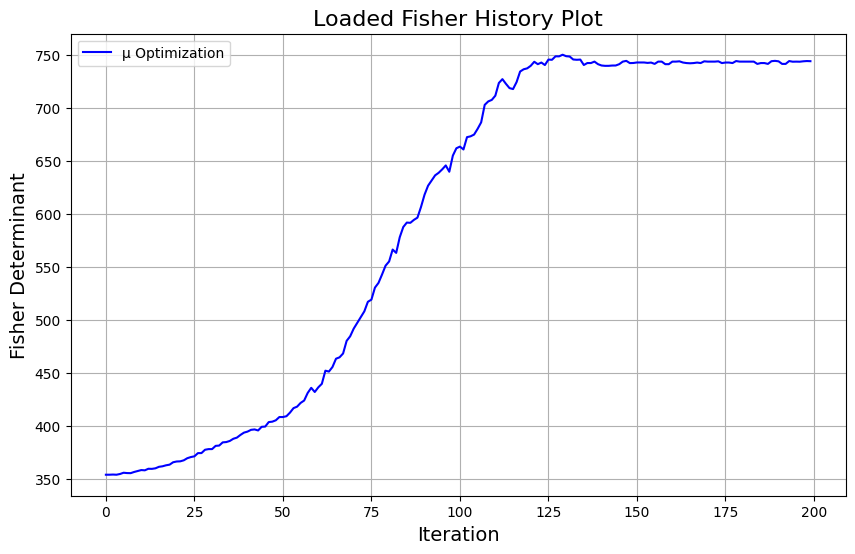

In [24]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(fisher_history, label='μ Optimization', color='blue', markersize=4)
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Fisher Determinant", fontsize=14)
plt.title("Loaded Fisher History Plot", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

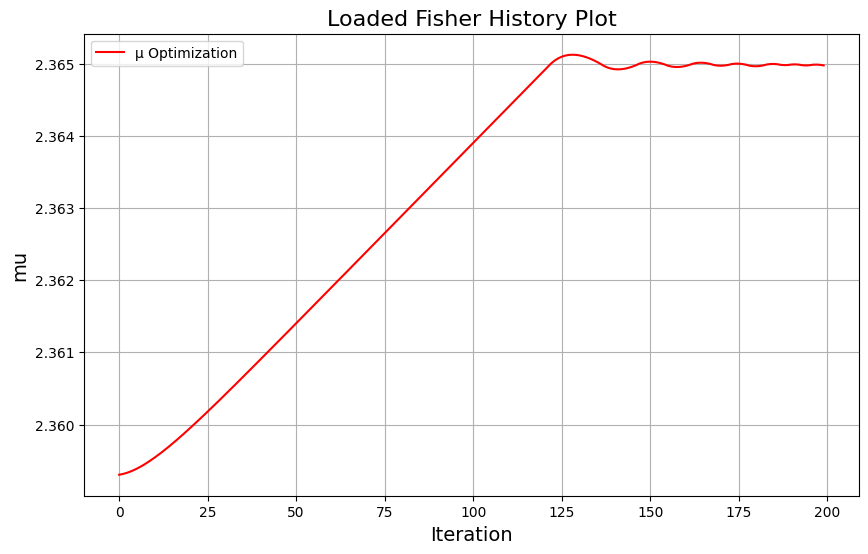

In [27]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(mu_history, label='μ Optimization', color='red', markersize=4)
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("mu", fontsize=14)
plt.title("Loaded Fisher History Plot", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

In [25]:
filename1_fi = f"C:/Users/tvle2/Documents/Code/Bosonic/dataset/fisher_history_10_new.txt"
filename1_mu = f"C:/Users/tvle2/Documents/Code/Bosonic/dataset/mu_10_new.txt"
with open(filename1_fi, "w") as file:
    for i, fisher_value in enumerate(fisher_history):
        file.write(f"{i} {fisher_value}\n")
with open(filename1_mu, "w") as file:
    for i, mu_value in enumerate(mu_history):
        file.write(f"{i} {mu_value}\n")


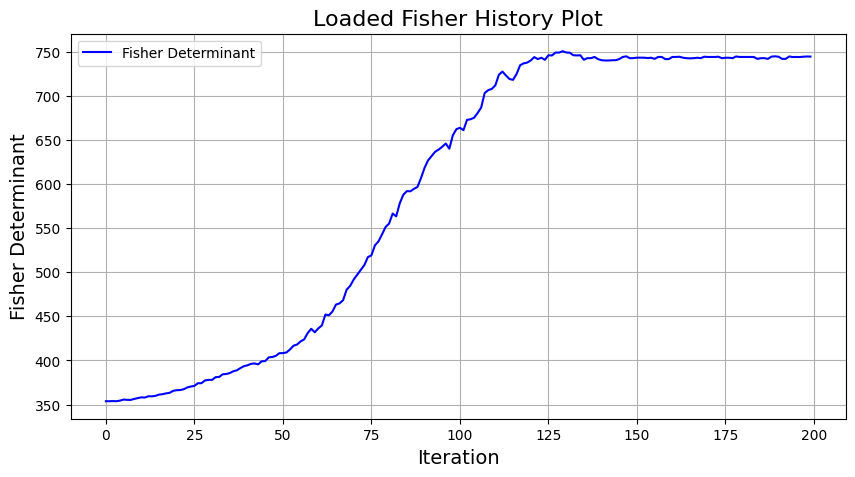

In [26]:
# Load data
iterations = []
fisher_values = []

with open(filename1_fi, "r") as file:
    for line in file:
        data = line.strip().split()  # Split by space
        if len(data) == 2:  # Ensure there are two values (iteration, fisher_value)
            iter_idx, fisher_value = int(data[0]), float(data[1])
            iterations.append(iter_idx)
            fisher_values.append(fisher_value)

# Convert to NumPy array (optional, for easier handling)
iterations = np.array(iterations)
fisher_values = np.array(fisher_values)

# Plot the loaded data
plt.figure(figsize=(10,5))
plt.plot(iterations, fisher_values, color='blue', label="Fisher Determinant")
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Fisher Determinant", fontsize=14)
plt.title("Loaded Fisher History Plot", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()


### CFI 11 dB

In [28]:
db = 11
epsilon = db_to_epsilon(db)  
mu = 2.3592999716910443
print(f"Initial mu: {mu:.4f}")

fisher_history, mu_history = [], []
momentum = 0.9
velocity = 0

for step in tqdm(range(num_steps)):
    # Evaluate F and its determinant at current mu
    F = classical_fisher(mu, epsilon, eta, delta)
    det_F = np.linalg.det(F)

    # Central difference for derivative wrt mu
    delta_mu = 1e-3
    det_F_minus = fisher_det_mu(mu - delta_mu, epsilon, eta, delta)
    det_F_plus  = fisher_det_mu(mu + delta_mu, epsilon, eta, delta)
    grad_mu = (det_F_plus - det_F_minus) / (2 * delta_mu)

    # Clip gradient
    grad_mu = np.clip(grad_mu, -0.01, 0.01)

    # Momentum-based gradient ascent update
    velocity = 0.9 * velocity + learning_rate * grad_mu
    mu += velocity
    mu %= (2 * np.pi)

    # # Gradient ascent step
    # mu += learning_rate * grad_mu
    # mu = mu % (2 * np.pi)

    fisher_history.append(det_F)
    mu_history.append(mu)

    if step % 1 == 0:
        print(f"Step {step}: mu={mu:.4f}, Fisher={det_F:.4e}")

Initial mu: 2.3593


  0%|          | 1/200 [02:18<7:37:42, 138.00s/it]

Step 0: mu=2.3593, Fisher=5.8046e+02


  1%|          | 2/200 [04:35<7:34:39, 137.77s/it]

Step 1: mu=2.3593, Fisher=5.8044e+02


  2%|▏         | 3/200 [06:52<7:31:40, 137.57s/it]

Step 2: mu=2.3593, Fisher=5.8057e+02


  2%|▏         | 4/200 [09:10<7:29:13, 137.52s/it]

Step 3: mu=2.3593, Fisher=5.8023e+02


  2%|▎         | 5/200 [11:27<7:26:51, 137.49s/it]

Step 4: mu=2.3594, Fisher=5.8150e+02


  3%|▎         | 6/200 [13:45<7:24:17, 137.41s/it]

Step 5: mu=2.3594, Fisher=5.8349e+02


  4%|▎         | 7/200 [16:02<7:22:10, 137.46s/it]

Step 6: mu=2.3594, Fisher=5.8367e+02


  4%|▍         | 8/200 [18:19<7:19:33, 137.36s/it]

Step 7: mu=2.3594, Fisher=5.8308e+02


  4%|▍         | 9/200 [20:37<7:17:07, 137.32s/it]

Step 8: mu=2.3595, Fisher=5.8533e+02


  5%|▌         | 10/200 [22:54<7:15:11, 137.43s/it]

Step 9: mu=2.3595, Fisher=5.8672e+02


  6%|▌         | 11/200 [25:12<7:12:56, 137.44s/it]

Step 10: mu=2.3595, Fisher=5.8895e+02


  6%|▌         | 12/200 [27:29<7:10:41, 137.45s/it]

Step 11: mu=2.3596, Fisher=5.8868e+02


  6%|▋         | 13/200 [29:47<7:08:21, 137.44s/it]

Step 12: mu=2.3596, Fisher=5.9147e+02


  7%|▋         | 14/200 [32:04<7:06:08, 137.47s/it]

Step 13: mu=2.3597, Fisher=5.9110e+02


  8%|▊         | 15/200 [34:22<7:03:55, 137.49s/it]

Step 14: mu=2.3597, Fisher=5.9199e+02


  8%|▊         | 16/200 [36:39<7:01:28, 137.44s/it]

Step 15: mu=2.3597, Fisher=5.9500e+02


  8%|▊         | 17/200 [38:56<6:58:59, 137.38s/it]

Step 16: mu=2.3598, Fisher=5.9633e+02


  9%|▉         | 18/200 [41:14<6:56:50, 137.42s/it]

Step 17: mu=2.3598, Fisher=5.9802e+02


 10%|▉         | 19/200 [43:31<6:54:29, 137.40s/it]

Step 18: mu=2.3599, Fisher=5.9967e+02


 10%|█         | 20/200 [45:49<6:52:18, 137.43s/it]

Step 19: mu=2.3599, Fisher=6.0358e+02


 10%|█         | 21/200 [48:06<6:49:41, 137.33s/it]

Step 20: mu=2.3599, Fisher=6.0529e+02


 11%|█         | 22/200 [50:23<6:47:12, 137.26s/it]

Step 21: mu=2.3600, Fisher=6.0593e+02


 12%|█▏        | 23/200 [52:40<6:44:59, 137.29s/it]

Step 22: mu=2.3600, Fisher=6.0835e+02


 12%|█▏        | 24/200 [54:57<6:42:43, 137.29s/it]

Step 23: mu=2.3601, Fisher=6.1225e+02


 12%|█▎        | 25/200 [57:15<6:40:24, 137.29s/it]

Step 24: mu=2.3601, Fisher=6.1387e+02


 13%|█▎        | 26/200 [59:32<6:38:09, 137.29s/it]

Step 25: mu=2.3602, Fisher=6.1538e+02


 14%|█▎        | 27/200 [1:01:49<6:35:42, 137.24s/it]

Step 26: mu=2.3602, Fisher=6.2147e+02


 14%|█▍        | 28/200 [1:04:07<6:33:40, 137.33s/it]

Step 27: mu=2.3603, Fisher=6.2146e+02


 14%|█▍        | 29/200 [1:06:24<6:31:20, 137.31s/it]

Step 28: mu=2.3603, Fisher=6.2718e+02


 15%|█▌        | 30/200 [1:08:41<6:29:04, 137.32s/it]

Step 29: mu=2.3604, Fisher=6.2834e+02


 16%|█▌        | 31/200 [1:10:59<6:26:57, 137.38s/it]

Step 30: mu=2.3604, Fisher=6.2843e+02


 16%|█▌        | 32/200 [1:13:16<6:24:32, 137.34s/it]

Step 31: mu=2.3605, Fisher=6.3513e+02


 16%|█▋        | 33/200 [1:15:33<6:22:15, 137.34s/it]

Step 32: mu=2.3605, Fisher=6.3585e+02


 17%|█▋        | 34/200 [1:17:51<6:19:49, 137.28s/it]

Step 33: mu=2.3606, Fisher=6.4088e+02


 18%|█▊        | 35/200 [1:20:08<6:17:27, 137.26s/it]

Step 34: mu=2.3606, Fisher=6.4162e+02


 18%|█▊        | 36/200 [1:22:25<6:15:23, 137.34s/it]

Step 35: mu=2.3607, Fisher=6.4222e+02


 18%|█▊        | 37/200 [1:24:42<6:12:51, 137.25s/it]

Step 36: mu=2.3607, Fisher=6.4710e+02


 19%|█▉        | 38/200 [1:27:00<6:10:41, 137.29s/it]

Step 37: mu=2.3608, Fisher=6.4865e+02


 20%|█▉        | 39/200 [1:29:17<6:08:35, 137.36s/it]

Step 38: mu=2.3608, Fisher=6.5195e+02


 20%|██        | 40/200 [1:31:34<6:06:06, 137.29s/it]

Step 39: mu=2.3609, Fisher=6.5501e+02


 20%|██        | 41/200 [1:33:52<6:03:53, 137.32s/it]

Step 40: mu=2.3609, Fisher=6.5607e+02


 21%|██        | 42/200 [1:36:09<6:01:27, 137.26s/it]

Step 41: mu=2.3610, Fisher=6.5945e+02


 22%|██▏       | 43/200 [1:38:26<5:59:10, 137.27s/it]

Step 42: mu=2.3610, Fisher=6.5994e+02


 22%|██▏       | 44/200 [1:40:44<5:57:00, 137.31s/it]

Step 43: mu=2.3611, Fisher=6.5739e+02


 22%|██▎       | 45/200 [1:43:01<5:54:46, 137.33s/it]

Step 44: mu=2.3611, Fisher=6.6214e+02


 23%|██▎       | 46/200 [1:46:34<6:51:09, 160.19s/it]

Step 45: mu=2.3612, Fisher=6.6209e+02


 24%|██▎       | 47/200 [1:49:02<6:39:00, 156.48s/it]

Step 46: mu=2.3612, Fisher=6.6703e+02


 24%|██▍       | 48/200 [1:51:19<6:21:30, 150.60s/it]

Step 47: mu=2.3613, Fisher=6.6815e+02


 24%|██▍       | 49/200 [1:53:36<6:08:40, 146.49s/it]

Step 48: mu=2.3613, Fisher=6.6970e+02


 25%|██▌       | 50/200 [1:55:53<5:58:48, 143.52s/it]

Step 49: mu=2.3614, Fisher=6.7339e+02


 26%|██▌       | 51/200 [1:58:09<5:51:15, 141.45s/it]

Step 50: mu=2.3614, Fisher=6.7316e+02


 26%|██▌       | 52/200 [2:00:26<5:45:25, 140.03s/it]

Step 51: mu=2.3615, Fisher=6.7360e+02


 26%|██▋       | 53/200 [2:02:43<5:40:46, 139.09s/it]

Step 52: mu=2.3615, Fisher=6.7860e+02


 27%|██▋       | 54/200 [2:05:00<5:37:04, 138.53s/it]

Step 53: mu=2.3616, Fisher=6.8467e+02


 28%|██▊       | 55/200 [2:07:17<5:33:45, 138.11s/it]

Step 54: mu=2.3616, Fisher=6.8759e+02


 28%|██▊       | 56/200 [2:09:34<5:30:49, 137.84s/it]

Step 55: mu=2.3617, Fisher=6.9267e+02


 28%|██▊       | 57/200 [2:11:51<5:27:51, 137.56s/it]

Step 56: mu=2.3617, Fisher=6.9581e+02


 29%|██▉       | 58/200 [2:15:00<6:02:00, 152.96s/it]

Step 57: mu=2.3618, Fisher=7.0618e+02


 30%|██▉       | 59/200 [2:19:03<7:02:43, 179.88s/it]

Step 58: mu=2.3618, Fisher=7.1390e+02


 30%|███       | 60/200 [2:21:18<6:28:32, 166.52s/it]

Step 59: mu=2.3619, Fisher=7.0800e+02


 30%|███       | 61/200 [2:23:34<6:04:07, 157.18s/it]

Step 60: mu=2.3619, Fisher=7.1412e+02


 31%|███       | 62/200 [2:25:49<5:46:29, 150.65s/it]

Step 61: mu=2.3620, Fisher=7.2015e+02


 32%|███▏      | 63/200 [2:28:05<5:33:45, 146.17s/it]

Step 62: mu=2.3620, Fisher=7.4062e+02


 32%|███▏      | 64/200 [2:30:20<5:23:54, 142.90s/it]

Step 63: mu=2.3621, Fisher=7.4038e+02


 32%|███▎      | 65/200 [2:32:35<5:16:27, 140.65s/it]

Step 64: mu=2.3621, Fisher=7.4868e+02


 33%|███▎      | 66/200 [2:34:51<5:10:35, 139.07s/it]

Step 65: mu=2.3622, Fisher=7.5890e+02


 34%|███▎      | 67/200 [2:37:06<5:05:54, 138.00s/it]

Step 66: mu=2.3622, Fisher=7.6400e+02


 34%|███▍      | 68/200 [2:39:22<5:02:03, 137.30s/it]

Step 67: mu=2.3623, Fisher=7.7036e+02


 34%|███▍      | 69/200 [2:41:37<4:58:32, 136.74s/it]

Step 68: mu=2.3623, Fisher=7.9084e+02


 35%|███▌      | 70/200 [2:43:53<4:55:30, 136.39s/it]

Step 69: mu=2.3624, Fisher=7.9867e+02


 36%|███▌      | 71/200 [2:46:08<4:52:25, 136.01s/it]

Step 70: mu=2.3624, Fisher=8.0946e+02


 36%|███▌      | 72/200 [2:48:24<4:49:54, 135.90s/it]

Step 71: mu=2.3625, Fisher=8.2215e+02


 36%|███▋      | 73/200 [2:50:39<4:47:20, 135.75s/it]

Step 72: mu=2.3625, Fisher=8.3237e+02


 37%|███▋      | 74/200 [2:52:54<4:44:46, 135.61s/it]

Step 73: mu=2.3626, Fisher=8.4476e+02


 38%|███▊      | 75/200 [2:55:10<4:42:39, 135.67s/it]

Step 74: mu=2.3626, Fisher=8.5996e+02


 38%|███▊      | 76/200 [2:57:26<4:40:20, 135.65s/it]

Step 75: mu=2.3627, Fisher=8.6504e+02


 38%|███▊      | 77/200 [2:59:42<4:38:35, 135.90s/it]

Step 76: mu=2.3627, Fisher=8.8651e+02


 39%|███▉      | 78/200 [3:01:58<4:36:01, 135.75s/it]

Step 77: mu=2.3628, Fisher=8.9402e+02


 40%|███▉      | 79/200 [3:04:13<4:33:33, 135.65s/it]

Step 78: mu=2.3628, Fisher=9.0818e+02


 40%|████      | 80/200 [3:06:29<4:31:06, 135.56s/it]

Step 79: mu=2.3629, Fisher=9.2536e+02


 40%|████      | 81/200 [3:08:44<4:28:53, 135.58s/it]

Step 80: mu=2.3629, Fisher=9.3581e+02


 41%|████      | 82/200 [3:10:59<4:26:29, 135.50s/it]

Step 81: mu=2.3630, Fisher=9.5809e+02


 42%|████▏     | 83/200 [3:13:15<4:24:12, 135.49s/it]

Step 82: mu=2.3630, Fisher=9.5139e+02


 42%|████▏     | 84/200 [3:15:30<4:21:59, 135.51s/it]

Step 83: mu=2.3631, Fisher=9.7755e+02


 42%|████▎     | 85/200 [3:17:46<4:19:45, 135.52s/it]

Step 84: mu=2.3631, Fisher=1.0003e+03


 43%|████▎     | 86/200 [3:20:02<4:17:35, 135.57s/it]

Step 85: mu=2.3632, Fisher=1.0083e+03


 44%|████▎     | 87/200 [3:22:17<4:15:13, 135.52s/it]

Step 86: mu=2.3632, Fisher=1.0102e+03


 44%|████▍     | 88/200 [3:24:33<4:12:57, 135.51s/it]

Step 87: mu=2.3633, Fisher=1.0152e+03


 44%|████▍     | 89/200 [3:26:49<4:11:02, 135.69s/it]

Step 88: mu=2.3633, Fisher=1.0221e+03


 45%|████▌     | 90/200 [3:29:04<4:08:34, 135.59s/it]

Step 89: mu=2.3634, Fisher=1.0456e+03


 46%|████▌     | 91/200 [3:31:19<4:06:10, 135.51s/it]

Step 90: mu=2.3634, Fisher=1.0636e+03


 46%|████▌     | 92/200 [3:33:31<4:01:57, 134.42s/it]

Step 91: mu=2.3634, Fisher=1.0798e+03


 46%|████▋     | 93/200 [3:35:41<3:57:26, 133.14s/it]

Step 92: mu=2.3635, Fisher=1.0926e+03


 47%|████▋     | 94/200 [3:37:52<3:53:40, 132.27s/it]

Step 93: mu=2.3635, Fisher=1.1024e+03


 48%|████▊     | 95/200 [3:40:03<3:50:48, 131.89s/it]

Step 94: mu=2.3636, Fisher=1.1113e+03


 48%|████▊     | 96/200 [3:42:13<3:47:42, 131.37s/it]

Step 95: mu=2.3636, Fisher=1.1193e+03


 48%|████▊     | 97/200 [3:44:23<3:44:57, 131.04s/it]

Step 96: mu=2.3637, Fisher=1.1281e+03


 49%|████▉     | 98/200 [3:46:33<3:42:02, 130.62s/it]

Step 97: mu=2.3637, Fisher=1.1172e+03


 50%|████▉     | 99/200 [3:48:43<3:39:45, 130.55s/it]

Step 98: mu=2.3638, Fisher=1.1462e+03


 50%|█████     | 100/200 [3:50:53<3:37:26, 130.47s/it]

Step 99: mu=2.3638, Fisher=1.1653e+03


 50%|█████     | 101/200 [3:53:04<3:35:18, 130.49s/it]

Step 100: mu=2.3639, Fisher=1.1691e+03


 51%|█████     | 102/200 [3:55:14<3:32:58, 130.39s/it]

Step 101: mu=2.3639, Fisher=1.1667e+03


 52%|█████▏    | 103/200 [3:57:24<3:30:42, 130.33s/it]

Step 102: mu=2.3640, Fisher=1.1900e+03


 52%|█████▏    | 104/200 [3:59:34<3:28:26, 130.27s/it]

Step 103: mu=2.3640, Fisher=1.1947e+03


 52%|█████▎    | 105/200 [4:01:44<3:26:08, 130.20s/it]

Step 104: mu=2.3641, Fisher=1.1981e+03


 53%|█████▎    | 106/200 [4:03:55<3:24:16, 130.39s/it]

Step 105: mu=2.3641, Fisher=1.2174e+03


 54%|█████▎    | 107/200 [4:06:06<3:22:06, 130.40s/it]

Step 106: mu=2.3642, Fisher=1.2302e+03


 54%|█████▍    | 108/200 [4:08:16<3:20:00, 130.44s/it]

Step 107: mu=2.3642, Fisher=1.2617e+03


 55%|█████▍    | 109/200 [4:10:26<3:17:32, 130.25s/it]

Step 108: mu=2.3643, Fisher=1.2700e+03


 55%|█████▌    | 110/200 [4:12:37<3:15:28, 130.32s/it]

Step 109: mu=2.3643, Fisher=1.2783e+03


 56%|█████▌    | 111/200 [4:14:47<3:13:15, 130.28s/it]

Step 110: mu=2.3644, Fisher=1.2888e+03


 56%|█████▌    | 112/200 [4:16:57<3:11:01, 130.25s/it]

Step 111: mu=2.3644, Fisher=1.3186e+03


 56%|█████▋    | 113/200 [4:19:07<3:09:00, 130.35s/it]

Step 112: mu=2.3645, Fisher=1.3271e+03


 57%|█████▋    | 114/200 [4:21:18<3:06:48, 130.33s/it]

Step 113: mu=2.3645, Fisher=1.3270e+03


 57%|█████▊    | 115/200 [4:23:27<3:04:22, 130.14s/it]

Step 114: mu=2.3646, Fisher=1.3202e+03


 58%|█████▊    | 116/200 [4:25:38<3:02:24, 130.30s/it]

Step 115: mu=2.3646, Fisher=1.3205e+03


 58%|█████▊    | 117/200 [4:27:48<3:00:08, 130.22s/it]

Step 116: mu=2.3647, Fisher=1.3391e+03


 59%|█████▉    | 118/200 [4:29:58<2:57:53, 130.17s/it]

Step 117: mu=2.3647, Fisher=1.3641e+03


 60%|█████▉    | 119/200 [4:32:09<2:55:50, 130.26s/it]

Step 118: mu=2.3648, Fisher=1.3696e+03


 60%|██████    | 120/200 [4:34:19<2:53:36, 130.20s/it]

Step 119: mu=2.3648, Fisher=1.3745e+03


 60%|██████    | 121/200 [4:36:29<2:51:27, 130.22s/it]

Step 120: mu=2.3649, Fisher=1.3775e+03


 61%|██████    | 122/200 [4:38:39<2:49:08, 130.11s/it]

Step 121: mu=2.3649, Fisher=1.3892e+03


 62%|██████▏   | 123/200 [4:40:49<2:46:56, 130.08s/it]

Step 122: mu=2.3650, Fisher=1.3845e+03


 62%|██████▏   | 124/200 [4:43:00<2:45:11, 130.41s/it]

Step 123: mu=2.3650, Fisher=1.3890e+03


 62%|██████▎   | 125/200 [4:45:10<2:42:56, 130.35s/it]

Step 124: mu=2.3651, Fisher=1.3834e+03


 63%|██████▎   | 126/200 [4:47:20<2:40:42, 130.30s/it]

Step 125: mu=2.3651, Fisher=1.3988e+03


 64%|██████▎   | 127/200 [4:49:31<2:38:41, 130.43s/it]

Step 126: mu=2.3652, Fisher=1.4107e+03


 64%|██████▍   | 128/200 [4:51:42<2:36:31, 130.44s/it]

Step 127: mu=2.3652, Fisher=1.4179e+03


 64%|██████▍   | 129/200 [4:53:52<2:34:20, 130.43s/it]

Step 128: mu=2.3652, Fisher=1.4197e+03


 65%|██████▌   | 130/200 [4:56:02<2:32:08, 130.41s/it]

Step 129: mu=2.3652, Fisher=1.4083e+03


 66%|██████▌   | 131/200 [4:58:13<2:30:06, 130.52s/it]

Step 130: mu=2.3652, Fisher=1.4083e+03


 66%|██████▌   | 132/200 [5:00:24<2:27:52, 130.48s/it]

Step 131: mu=2.3652, Fisher=1.4083e+03


 66%|██████▋   | 133/200 [5:02:34<2:25:38, 130.42s/it]

Step 132: mu=2.3652, Fisher=1.4083e+03


 67%|██████▋   | 134/200 [5:04:44<2:23:22, 130.34s/it]

Step 133: mu=2.3652, Fisher=1.4083e+03


 68%|██████▊   | 135/200 [5:06:55<2:21:23, 130.52s/it]

Step 134: mu=2.3652, Fisher=1.4212e+03


 68%|██████▊   | 136/200 [5:09:05<2:19:11, 130.49s/it]

Step 135: mu=2.3652, Fisher=1.4209e+03


 68%|██████▊   | 137/200 [5:11:16<2:16:57, 130.43s/it]

Step 136: mu=2.3651, Fisher=1.4162e+03


 69%|██████▉   | 138/200 [5:13:27<2:15:01, 130.68s/it]

Step 137: mu=2.3651, Fisher=1.4089e+03


 70%|██████▉   | 139/200 [5:15:37<2:12:40, 130.50s/it]

Step 138: mu=2.3651, Fisher=1.4103e+03


 70%|███████   | 140/200 [5:17:47<2:10:25, 130.42s/it]

Step 139: mu=2.3651, Fisher=1.3983e+03


 70%|███████   | 141/200 [5:19:58<2:08:13, 130.40s/it]

Step 140: mu=2.3650, Fisher=1.4034e+03


 71%|███████   | 142/200 [5:22:08<2:05:59, 130.34s/it]

Step 141: mu=2.3650, Fisher=1.3820e+03


 72%|███████▏  | 143/200 [5:24:18<2:03:41, 130.21s/it]

Step 142: mu=2.3650, Fisher=1.3878e+03


 72%|███████▏  | 144/200 [5:26:29<2:01:42, 130.39s/it]

Step 143: mu=2.3650, Fisher=1.3857e+03


 72%|███████▎  | 145/200 [5:28:39<1:59:31, 130.40s/it]

Step 144: mu=2.3650, Fisher=1.3851e+03


 73%|███████▎  | 146/200 [5:30:49<1:57:17, 130.32s/it]

Step 145: mu=2.3650, Fisher=1.3878e+03


 74%|███████▎  | 147/200 [5:32:59<1:55:03, 130.25s/it]

Step 146: mu=2.3650, Fisher=1.3878e+03


 74%|███████▍  | 148/200 [5:35:09<1:52:51, 130.23s/it]

Step 147: mu=2.3651, Fisher=1.3820e+03


 74%|███████▍  | 149/200 [5:37:20<1:50:45, 130.31s/it]

Step 148: mu=2.3651, Fisher=1.3838e+03


 75%|███████▌  | 150/200 [5:39:30<1:48:30, 130.21s/it]

Step 149: mu=2.3651, Fisher=1.3974e+03


 76%|███████▌  | 151/200 [5:41:40<1:46:18, 130.18s/it]

Step 150: mu=2.3651, Fisher=1.3988e+03


 76%|███████▌  | 152/200 [5:43:50<1:44:09, 130.20s/it]

Step 151: mu=2.3651, Fisher=1.4068e+03


 76%|███████▋  | 153/200 [5:46:00<1:41:58, 130.17s/it]

Step 152: mu=2.3651, Fisher=1.4097e+03


 77%|███████▋  | 154/200 [5:48:10<1:39:45, 130.13s/it]

Step 153: mu=2.3651, Fisher=1.4086e+03


 78%|███████▊  | 155/200 [5:50:21<1:37:38, 130.19s/it]

Step 154: mu=2.3651, Fisher=1.4097e+03


 78%|███████▊  | 156/200 [5:52:31<1:35:26, 130.14s/it]

Step 155: mu=2.3651, Fisher=1.4068e+03


 78%|███████▊  | 157/200 [5:54:41<1:33:18, 130.19s/it]

Step 156: mu=2.3651, Fisher=1.4059e+03


 79%|███████▉  | 158/200 [5:56:52<1:31:12, 130.29s/it]

Step 157: mu=2.3651, Fisher=1.3964e+03


 80%|███████▉  | 159/200 [5:59:01<1:28:58, 130.20s/it]

Step 158: mu=2.3651, Fisher=1.3977e+03


 80%|████████  | 160/200 [6:01:13<1:26:58, 130.47s/it]

Step 159: mu=2.3651, Fisher=1.3838e+03


 80%|████████  | 161/200 [6:03:23<1:24:45, 130.41s/it]

Step 160: mu=2.3651, Fisher=1.3834e+03


 81%|████████  | 162/200 [6:05:33<1:22:30, 130.29s/it]

Step 161: mu=2.3651, Fisher=1.3834e+03


 82%|████████▏ | 163/200 [6:07:43<1:20:21, 130.31s/it]

Step 162: mu=2.3651, Fisher=1.3837e+03


 82%|████████▏ | 164/200 [6:09:53<1:18:09, 130.26s/it]

Step 163: mu=2.3651, Fisher=1.4021e+03


 82%|████████▎ | 165/200 [6:12:04<1:15:59, 130.28s/it]

Step 164: mu=2.3651, Fisher=1.3976e+03


 83%|████████▎ | 166/200 [6:14:14<1:13:51, 130.34s/it]

Step 165: mu=2.3651, Fisher=1.3981e+03


 84%|████████▎ | 167/200 [6:16:24<1:11:38, 130.25s/it]

Step 166: mu=2.3651, Fisher=1.4053e+03


 84%|████████▍ | 168/200 [6:18:34<1:09:24, 130.15s/it]

Step 167: mu=2.3651, Fisher=1.4068e+03


 84%|████████▍ | 169/200 [6:20:44<1:07:15, 130.19s/it]

Step 168: mu=2.3651, Fisher=1.4075e+03


 85%|████████▌ | 170/200 [6:22:54<1:05:04, 130.15s/it]

Step 169: mu=2.3651, Fisher=1.4059e+03


 86%|████████▌ | 171/200 [6:25:05<1:02:56, 130.24s/it]

Step 170: mu=2.3651, Fisher=1.3983e+03


 86%|████████▌ | 172/200 [6:27:15<1:00:41, 130.05s/it]

Step 171: mu=2.3651, Fisher=1.3976e+03


 86%|████████▋ | 173/200 [6:29:24<58:30, 130.01s/it]  

Step 172: mu=2.3651, Fisher=1.3977e+03


 87%|████████▋ | 174/200 [6:31:35<56:22, 130.09s/it]

Step 173: mu=2.3651, Fisher=1.3977e+03


 88%|████████▊ | 175/200 [6:33:45<54:11, 130.05s/it]

Step 174: mu=2.3651, Fisher=1.3973e+03


 88%|████████▊ | 176/200 [6:35:55<52:03, 130.14s/it]

Step 175: mu=2.3651, Fisher=1.3976e+03


 88%|████████▊ | 177/200 [6:38:05<49:54, 130.21s/it]

Step 176: mu=2.3651, Fisher=1.3985e+03


 89%|████████▉ | 178/200 [6:40:15<47:43, 130.15s/it]

Step 177: mu=2.3651, Fisher=1.3987e+03


 90%|████████▉ | 179/200 [6:42:26<45:34, 130.21s/it]

Step 178: mu=2.3651, Fisher=1.3987e+03


 90%|█████████ | 180/200 [6:44:36<43:24, 130.21s/it]

Step 179: mu=2.3651, Fisher=1.3983e+03


 90%|█████████ | 181/200 [6:46:46<41:12, 130.14s/it]

Step 180: mu=2.3651, Fisher=1.3968e+03


 91%|█████████ | 182/200 [6:48:56<39:04, 130.25s/it]

Step 181: mu=2.3651, Fisher=1.3976e+03


 92%|█████████▏| 183/200 [6:51:07<36:54, 130.26s/it]

Step 182: mu=2.3651, Fisher=1.3978e+03


 92%|█████████▏| 184/200 [6:53:18<34:48, 130.50s/it]

Step 183: mu=2.3651, Fisher=1.3964e+03


 92%|█████████▎| 185/200 [6:55:28<32:36, 130.42s/it]

Step 184: mu=2.3651, Fisher=1.3964e+03


 93%|█████████▎| 186/200 [6:57:38<30:22, 130.15s/it]

Step 185: mu=2.3651, Fisher=1.3972e+03


 94%|█████████▎| 187/200 [6:59:48<28:11, 130.14s/it]

Step 186: mu=2.3651, Fisher=1.3976e+03


 94%|█████████▍| 188/200 [7:01:58<26:03, 130.27s/it]

Step 187: mu=2.3651, Fisher=1.3974e+03


 94%|█████████▍| 189/200 [7:04:08<23:52, 130.22s/it]

Step 188: mu=2.3651, Fisher=1.3974e+03


 95%|█████████▌| 190/200 [7:06:19<21:42, 130.30s/it]

Step 189: mu=2.3651, Fisher=1.3972e+03


 96%|█████████▌| 191/200 [7:08:29<19:32, 130.30s/it]

Step 190: mu=2.3651, Fisher=1.3984e+03


 96%|█████████▌| 192/200 [7:10:39<17:21, 130.22s/it]

Step 191: mu=2.3651, Fisher=1.3987e+03


 96%|█████████▋| 193/200 [7:12:49<15:11, 130.18s/it]

Step 192: mu=2.3651, Fisher=1.3987e+03


 97%|█████████▋| 194/200 [7:15:00<13:01, 130.25s/it]

Step 193: mu=2.3651, Fisher=1.3984e+03


 98%|█████████▊| 195/200 [7:17:10<10:51, 130.23s/it]

Step 194: mu=2.3651, Fisher=1.3972e+03


 98%|█████████▊| 196/200 [7:19:20<08:41, 130.30s/it]

Step 195: mu=2.3651, Fisher=1.3976e+03


 98%|█████████▊| 197/200 [7:21:30<06:30, 130.23s/it]

Step 196: mu=2.3651, Fisher=1.4021e+03


 99%|█████████▉| 198/200 [7:23:40<04:20, 130.08s/it]

Step 197: mu=2.3651, Fisher=1.4034e+03


100%|█████████▉| 199/200 [7:25:51<02:10, 130.25s/it]

Step 198: mu=2.3651, Fisher=1.3977e+03


100%|██████████| 200/200 [7:28:01<00:00, 134.41s/it]

Step 199: mu=2.3651, Fisher=1.3972e+03


In [29]:
filename2_fi = f"C:/Users/tvle2/Documents/Code/Bosonic/dataset/fisher_history_11_new.txt"
filename2_mu = f"C:/Users/tvle2/Documents/Code/Bosonic/dataset/mu_11_new.txt"
with open(filename2_fi, "w") as file:
    for i, fisher_value in enumerate(fisher_history):
        file.write(f"{i} {fisher_value}\n")
with open(filename2_mu, "w") as file:
    for i, mu_value in enumerate(mu_history):
        file.write(f"{i} {mu_value}\n")


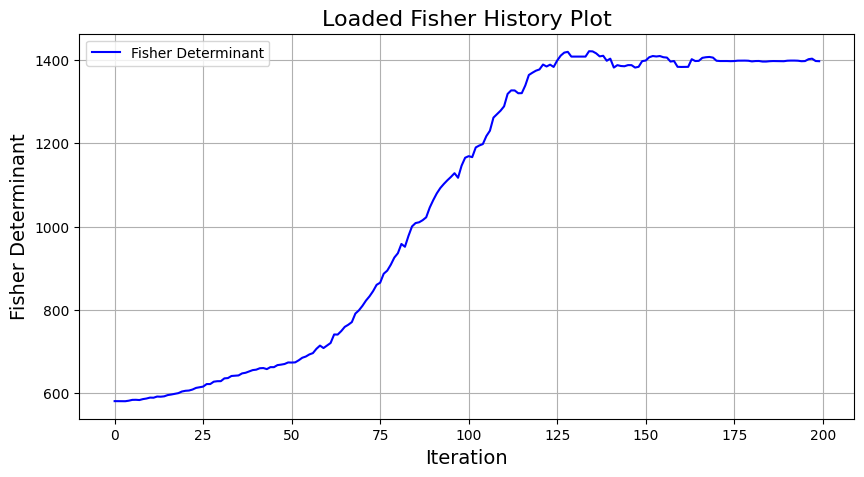

In [30]:
# Load data
iterations = []
fisher_values = []

with open(filename2_fi, "r") as file:
    for line in file:
        data = line.strip().split()  # Split by space
        if len(data) == 2:  # Ensure there are two values (iteration, fisher_value)
            iter_idx, fisher_value = int(data[0]), float(data[1])
            iterations.append(iter_idx)
            fisher_values.append(fisher_value)

# Convert to NumPy array (optional, for easier handling)
iterations = np.array(iterations)
fisher_values = np.array(fisher_values)

# Plot the loaded data
plt.figure(figsize=(10,5))
plt.plot(iterations, fisher_values, color='blue', label="Fisher Determinant")
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Fisher Determinant", fontsize=14)
plt.title("Loaded Fisher History Plot", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()


### CFI 12 dB

In [31]:
db = 12
epsilon = db_to_epsilon(db)  
mu = 2.3592999716910443
print(f"Initial mu: {mu:.4f}")

fisher_history, mu_history = [], []
momentum = 0.9
velocity = 0

for step in tqdm(range(num_steps)):
    # Evaluate F and its determinant at current mu
    F = classical_fisher(mu, epsilon, eta, delta)
    det_F = np.linalg.det(F)

    # Central difference for derivative wrt mu
    delta_mu = 1e-3
    det_F_minus = fisher_det_mu(mu - delta_mu, epsilon, eta, delta)
    det_F_plus  = fisher_det_mu(mu + delta_mu, epsilon, eta, delta)
    grad_mu = (det_F_plus - det_F_minus) / (2 * delta_mu)

    # Clip gradient
    grad_mu = np.clip(grad_mu, -0.01, 0.01)

    # Momentum-based gradient ascent update
    velocity = 0.9 * velocity + learning_rate * grad_mu
    mu += velocity
    mu %= (2 * np.pi)

    # # Gradient ascent step
    # mu += learning_rate * grad_mu
    # mu = mu % (2 * np.pi)

    fisher_history.append(det_F)
    mu_history.append(mu)

    if step % 1 == 0:
        print(f"Step {step}: mu={mu:.4f}, Fisher={det_F:.4e}")

Initial mu: 2.3593


  0%|          | 1/200 [02:36<8:38:55, 156.46s/it]

Step 0: mu=2.3593, Fisher=9.0602e+02


  1%|          | 2/200 [05:13<8:36:47, 156.60s/it]

Step 1: mu=2.3593, Fisher=9.0592e+02


  2%|▏         | 3/200 [07:49<8:34:10, 156.60s/it]

Step 2: mu=2.3593, Fisher=9.0600e+02


  2%|▏         | 4/200 [10:26<8:31:49, 156.68s/it]

Step 3: mu=2.3593, Fisher=9.0539e+02


  2%|▎         | 5/200 [13:03<8:29:01, 156.62s/it]

Step 4: mu=2.3594, Fisher=9.0733e+02


  3%|▎         | 6/200 [15:39<8:26:11, 156.55s/it]

Step 5: mu=2.3594, Fisher=9.1036e+02


  4%|▎         | 7/200 [18:16<8:23:59, 156.68s/it]

Step 6: mu=2.3594, Fisher=9.1159e+02


  4%|▍         | 8/200 [20:52<8:21:04, 156.59s/it]

Step 7: mu=2.3594, Fisher=9.1013e+02


  4%|▍         | 9/200 [23:29<8:18:51, 156.71s/it]

Step 8: mu=2.3595, Fisher=9.1382e+02


  5%|▌         | 10/200 [26:06<8:15:48, 156.57s/it]

Step 9: mu=2.3595, Fisher=9.1569e+02


  6%|▌         | 11/200 [28:43<8:13:42, 156.73s/it]

Step 10: mu=2.3595, Fisher=9.2013e+02


  6%|▌         | 12/200 [31:20<8:11:41, 156.92s/it]

Step 11: mu=2.3596, Fisher=9.1996e+02


  6%|▋         | 13/200 [33:56<8:08:24, 156.71s/it]

Step 12: mu=2.3596, Fisher=9.2440e+02


  7%|▋         | 14/200 [36:33<8:05:43, 156.69s/it]

Step 13: mu=2.3597, Fisher=9.2387e+02


  8%|▊         | 15/200 [39:09<8:02:46, 156.58s/it]

Step 14: mu=2.3597, Fisher=9.2582e+02


  8%|▊         | 16/200 [41:46<8:00:23, 156.65s/it]

Step 15: mu=2.3597, Fisher=9.3099e+02


  8%|▊         | 17/200 [44:22<7:57:27, 156.54s/it]

Step 16: mu=2.3598, Fisher=9.3351e+02


  9%|▉         | 18/200 [46:59<7:55:01, 156.60s/it]

Step 17: mu=2.3598, Fisher=9.3620e+02


 10%|▉         | 19/200 [49:36<7:52:36, 156.67s/it]

Step 18: mu=2.3599, Fisher=9.4044e+02


 10%|█         | 20/200 [52:13<7:50:05, 156.70s/it]

Step 19: mu=2.3599, Fisher=9.4641e+02


 10%|█         | 21/200 [54:50<7:47:40, 156.76s/it]

Step 20: mu=2.3599, Fisher=9.4985e+02


 11%|█         | 22/200 [57:27<7:45:22, 156.87s/it]

Step 21: mu=2.3600, Fisher=9.5135e+02


 12%|█▏        | 23/200 [1:00:04<7:43:04, 156.98s/it]

Step 22: mu=2.3600, Fisher=9.5710e+02


 12%|█▏        | 24/200 [1:02:40<7:39:55, 156.79s/it]

Step 23: mu=2.3601, Fisher=9.6371e+02


 12%|█▎        | 25/200 [1:05:18<7:37:47, 156.96s/it]

Step 24: mu=2.3601, Fisher=9.6612e+02


 13%|█▎        | 26/200 [1:07:55<7:35:13, 156.97s/it]

Step 25: mu=2.3602, Fisher=9.6938e+02


 14%|█▎        | 27/200 [1:10:32<7:32:46, 157.03s/it]

Step 26: mu=2.3602, Fisher=9.8113e+02


 14%|█▍        | 28/200 [1:13:09<7:30:22, 157.11s/it]

Step 27: mu=2.3603, Fisher=9.8101e+02


 14%|█▍        | 29/200 [1:15:46<7:27:37, 157.06s/it]

Step 28: mu=2.3603, Fisher=9.9074e+02


 15%|█▌        | 30/200 [1:18:23<7:25:06, 157.10s/it]

Step 29: mu=2.3604, Fisher=9.9278e+02


 16%|█▌        | 31/200 [1:21:00<7:21:50, 156.87s/it]

Step 30: mu=2.3604, Fisher=9.9311e+02


 16%|█▌        | 32/200 [1:23:37<7:19:21, 156.91s/it]

Step 31: mu=2.3605, Fisher=1.0088e+03


 16%|█▋        | 33/200 [1:26:14<7:17:32, 157.20s/it]

Step 32: mu=2.3605, Fisher=1.0103e+03


 17%|█▋        | 34/200 [1:28:51<7:14:39, 157.10s/it]

Step 33: mu=2.3606, Fisher=1.0179e+03


 18%|█▊        | 35/200 [1:31:28<7:11:41, 156.98s/it]

Step 34: mu=2.3606, Fisher=1.0200e+03


 18%|█▊        | 36/200 [1:34:05<7:09:03, 156.97s/it]

Step 35: mu=2.3607, Fisher=1.0191e+03


 18%|█▊        | 37/200 [1:36:42<7:06:20, 156.93s/it]

Step 36: mu=2.3607, Fisher=1.0304e+03


 19%|█▉        | 38/200 [1:39:19<7:03:36, 156.89s/it]

Step 37: mu=2.3608, Fisher=1.0328e+03


 20%|█▉        | 39/200 [1:41:55<7:00:53, 156.86s/it]

Step 38: mu=2.3608, Fisher=1.0364e+03


 20%|██        | 40/200 [1:44:32<6:58:13, 156.83s/it]

Step 39: mu=2.3609, Fisher=1.0401e+03


 20%|██        | 41/200 [1:47:09<6:55:43, 156.88s/it]

Step 40: mu=2.3609, Fisher=1.0411e+03


 21%|██        | 42/200 [1:49:46<6:52:47, 156.75s/it]

Step 41: mu=2.3610, Fisher=1.0495e+03


 22%|██▏       | 43/200 [1:52:22<6:50:13, 156.77s/it]

Step 42: mu=2.3610, Fisher=1.0502e+03


 22%|██▏       | 44/200 [1:54:59<6:47:30, 156.73s/it]

Step 43: mu=2.3611, Fisher=1.0454e+03


 22%|██▎       | 45/200 [1:57:36<6:44:42, 156.66s/it]

Step 44: mu=2.3611, Fisher=1.0511e+03


 23%|██▎       | 46/200 [2:00:12<6:42:05, 156.66s/it]

Step 45: mu=2.3612, Fisher=1.0504e+03


 24%|██▎       | 47/200 [2:02:49<6:39:53, 156.82s/it]

Step 46: mu=2.3612, Fisher=1.0550e+03


 24%|██▍       | 48/200 [2:05:26<6:37:24, 156.87s/it]

Step 47: mu=2.3613, Fisher=1.0602e+03


 24%|██▍       | 49/200 [2:08:03<6:34:43, 156.84s/it]

Step 48: mu=2.3613, Fisher=1.0616e+03


 25%|██▌       | 50/200 [2:10:40<6:32:00, 156.80s/it]

Step 49: mu=2.3614, Fisher=1.0653e+03


 26%|██▌       | 51/200 [2:13:17<6:29:38, 156.90s/it]

Step 50: mu=2.3614, Fisher=1.0645e+03


 26%|██▌       | 52/200 [2:15:54<6:27:02, 156.91s/it]

Step 51: mu=2.3615, Fisher=1.0641e+03


 26%|██▋       | 53/200 [2:18:31<6:24:44, 157.04s/it]

Step 52: mu=2.3615, Fisher=1.0714e+03


 27%|██▋       | 54/200 [2:21:09<6:22:32, 157.21s/it]

Step 53: mu=2.3616, Fisher=1.0790e+03


 28%|██▊       | 55/200 [2:23:46<6:19:43, 157.13s/it]

Step 54: mu=2.3616, Fisher=1.0874e+03


 28%|██▊       | 56/200 [2:26:23<6:16:57, 157.07s/it]

Step 55: mu=2.3617, Fisher=1.0946e+03


 28%|██▊       | 57/200 [2:29:00<6:14:17, 157.04s/it]

Step 56: mu=2.3617, Fisher=1.0989e+03


 29%|██▉       | 58/200 [2:31:37<6:11:32, 156.99s/it]

Step 57: mu=2.3618, Fisher=1.1125e+03


 30%|██▉       | 59/200 [2:34:14<6:08:58, 157.01s/it]

Step 58: mu=2.3618, Fisher=1.1244e+03


 30%|███       | 60/200 [2:36:51<6:06:16, 156.97s/it]

Step 59: mu=2.3619, Fisher=1.1168e+03


 30%|███       | 61/200 [2:39:28<6:03:41, 156.99s/it]

Step 60: mu=2.3619, Fisher=1.1249e+03


 31%|███       | 62/200 [2:42:05<6:01:12, 157.04s/it]

Step 61: mu=2.3620, Fisher=1.1355e+03


 32%|███▏      | 63/200 [2:44:42<5:58:25, 156.98s/it]

Step 62: mu=2.3620, Fisher=1.1694e+03


 32%|███▏      | 64/200 [2:47:19<5:56:13, 157.16s/it]

Step 63: mu=2.3621, Fisher=1.1707e+03


 32%|███▎      | 65/200 [2:49:56<5:53:43, 157.21s/it]

Step 64: mu=2.3621, Fisher=1.1860e+03


 33%|███▎      | 66/200 [2:52:34<5:51:08, 157.23s/it]

Step 65: mu=2.3622, Fisher=1.1983e+03


 34%|███▎      | 67/200 [2:55:11<5:48:14, 157.10s/it]

Step 66: mu=2.3622, Fisher=1.2155e+03


 34%|███▍      | 68/200 [2:57:47<5:45:29, 157.04s/it]

Step 67: mu=2.3623, Fisher=1.2259e+03


 34%|███▍      | 69/200 [3:00:25<5:42:57, 157.08s/it]

Step 68: mu=2.3623, Fisher=1.2592e+03


 35%|███▌      | 70/200 [3:03:01<5:40:11, 157.01s/it]

Step 69: mu=2.3624, Fisher=1.2804e+03


 36%|███▌      | 71/200 [3:05:39<5:37:57, 157.19s/it]

Step 70: mu=2.3624, Fisher=1.2947e+03


 36%|███▌      | 72/200 [3:08:16<5:35:17, 157.17s/it]

Step 71: mu=2.3625, Fisher=1.3248e+03


 36%|███▋      | 73/200 [3:10:53<5:32:35, 157.13s/it]

Step 72: mu=2.3625, Fisher=1.3428e+03


 37%|███▋      | 74/200 [3:13:30<5:29:39, 156.98s/it]

Step 73: mu=2.3626, Fisher=1.3785e+03


 38%|███▊      | 75/200 [3:16:07<5:27:17, 157.10s/it]

Step 74: mu=2.3626, Fisher=1.4027e+03


 38%|███▊      | 76/200 [3:18:44<5:24:21, 156.95s/it]

Step 75: mu=2.3627, Fisher=1.4136e+03


 38%|███▊      | 77/200 [3:21:21<5:21:48, 156.98s/it]

Step 76: mu=2.3627, Fisher=1.4656e+03


 39%|███▉      | 78/200 [3:23:58<5:19:15, 157.01s/it]

Step 77: mu=2.3628, Fisher=1.4785e+03


 40%|███▉      | 79/200 [3:26:35<5:16:26, 156.92s/it]

Step 78: mu=2.3628, Fisher=1.5011e+03


 40%|████      | 80/200 [3:29:12<5:13:53, 156.94s/it]

Step 79: mu=2.3629, Fisher=1.5341e+03


 40%|████      | 81/200 [3:31:48<5:10:56, 156.78s/it]

Step 80: mu=2.3629, Fisher=1.5759e+03


 41%|████      | 82/200 [3:34:26<5:08:50, 157.04s/it]

Step 81: mu=2.3630, Fisher=1.6264e+03


 42%|████▏     | 83/200 [3:37:02<5:06:04, 156.96s/it]

Step 82: mu=2.3630, Fisher=1.6144e+03


 42%|████▏     | 84/200 [3:39:39<5:03:14, 156.85s/it]

Step 83: mu=2.3631, Fisher=1.6578e+03


 42%|████▎     | 85/200 [3:42:16<5:00:35, 156.83s/it]

Step 84: mu=2.3631, Fisher=1.7315e+03


 43%|████▎     | 86/200 [3:44:53<4:57:55, 156.80s/it]

Step 85: mu=2.3632, Fisher=1.7458e+03


 44%|████▎     | 87/200 [3:47:30<4:55:29, 156.90s/it]

Step 86: mu=2.3632, Fisher=1.7516e+03


 44%|████▍     | 88/200 [3:50:07<4:52:53, 156.91s/it]

Step 87: mu=2.3633, Fisher=1.7622e+03


 44%|████▍     | 89/200 [3:52:46<4:51:36, 157.63s/it]

Step 88: mu=2.3633, Fisher=1.7804e+03


 45%|████▌     | 90/200 [3:55:23<4:48:39, 157.45s/it]

Step 89: mu=2.3634, Fisher=1.8576e+03


 46%|████▌     | 91/200 [3:58:00<4:45:38, 157.24s/it]

Step 90: mu=2.3634, Fisher=1.8831e+03


 46%|████▌     | 92/200 [4:00:37<4:43:07, 157.29s/it]

Step 91: mu=2.3634, Fisher=1.9134e+03


 46%|████▋     | 93/200 [4:03:14<4:40:26, 157.25s/it]

Step 92: mu=2.3635, Fisher=1.9417e+03


 47%|████▋     | 94/200 [4:05:51<4:37:38, 157.16s/it]

Step 93: mu=2.3635, Fisher=1.9613e+03


 48%|████▊     | 95/200 [4:08:28<4:34:44, 156.99s/it]

Step 94: mu=2.3636, Fisher=2.0297e+03


 48%|████▊     | 96/200 [4:11:05<4:32:16, 157.08s/it]

Step 95: mu=2.3636, Fisher=2.0488e+03


 48%|████▊     | 97/200 [4:13:42<4:29:26, 156.96s/it]

Step 96: mu=2.3637, Fisher=2.0686e+03


 49%|████▉     | 98/200 [4:16:19<4:26:53, 157.00s/it]

Step 97: mu=2.3637, Fisher=2.0490e+03


 50%|████▉     | 99/200 [4:18:56<4:24:24, 157.08s/it]

Step 98: mu=2.3638, Fisher=2.1010e+03


 50%|█████     | 100/200 [4:21:33<4:21:43, 157.04s/it]

Step 99: mu=2.3638, Fisher=2.1726e+03


 50%|█████     | 101/200 [4:24:10<4:19:09, 157.07s/it]

Step 100: mu=2.3639, Fisher=2.1817e+03


 51%|█████     | 102/200 [4:26:47<4:16:33, 157.07s/it]

Step 101: mu=2.3639, Fisher=2.1816e+03


 52%|█████▏    | 103/200 [4:29:24<4:13:52, 157.03s/it]

Step 102: mu=2.3640, Fisher=2.2255e+03


 52%|█████▏    | 104/200 [4:32:01<4:11:08, 156.96s/it]

Step 103: mu=2.3640, Fisher=2.2430e+03


 52%|█████▎    | 105/200 [4:34:38<4:08:28, 156.93s/it]

Step 104: mu=2.3641, Fisher=2.2640e+03


 53%|█████▎    | 106/200 [4:37:15<4:05:52, 156.94s/it]

Step 105: mu=2.3641, Fisher=2.3226e+03


 54%|█████▎    | 107/200 [4:39:52<4:03:10, 156.89s/it]

Step 106: mu=2.3642, Fisher=2.3465e+03


 54%|█████▍    | 108/200 [4:42:29<4:00:42, 156.99s/it]

Step 107: mu=2.3642, Fisher=2.4061e+03


 55%|█████▍    | 109/200 [4:45:06<3:58:14, 157.08s/it]

Step 108: mu=2.3643, Fisher=2.4307e+03


 55%|█████▌    | 110/200 [4:47:43<3:55:32, 157.03s/it]

Step 109: mu=2.3643, Fisher=2.4666e+03


 56%|█████▌    | 111/200 [4:50:20<3:52:53, 157.01s/it]

Step 110: mu=2.3644, Fisher=2.4969e+03


 56%|█████▌    | 112/200 [4:52:57<3:50:23, 157.09s/it]

Step 111: mu=2.3644, Fisher=2.5669e+03


 56%|█████▋    | 113/200 [4:55:34<3:47:47, 157.09s/it]

Step 112: mu=2.3645, Fisher=2.5862e+03


 57%|█████▋    | 114/200 [4:58:12<3:45:21, 157.23s/it]

Step 113: mu=2.3645, Fisher=2.6012e+03


 57%|█████▊    | 115/200 [5:00:49<3:42:35, 157.13s/it]

Step 114: mu=2.3646, Fisher=2.5884e+03


 58%|█████▊    | 116/200 [5:03:28<3:40:46, 157.69s/it]

Step 115: mu=2.3646, Fisher=2.5930e+03


 58%|█████▊    | 117/200 [5:06:06<3:38:16, 157.79s/it]

Step 116: mu=2.3647, Fisher=2.6376e+03


 59%|█████▉    | 118/200 [5:08:43<3:35:16, 157.52s/it]

Step 117: mu=2.3647, Fisher=2.6907e+03


 60%|█████▉    | 119/200 [5:11:22<3:33:33, 158.19s/it]

Step 118: mu=2.3648, Fisher=2.7024e+03


 60%|██████    | 120/200 [5:15:56<4:17:02, 192.79s/it]

Step 119: mu=2.3648, Fisher=2.7174e+03


 60%|██████    | 121/200 [5:19:49<4:29:42, 204.85s/it]

Step 120: mu=2.3649, Fisher=2.7181e+03


 61%|██████    | 122/200 [5:22:35<4:10:59, 193.08s/it]

Step 121: mu=2.3649, Fisher=2.7437e+03


 62%|██████▏   | 123/200 [5:25:20<3:57:12, 184.84s/it]

Step 122: mu=2.3650, Fisher=2.7337e+03


 62%|██████▏   | 124/200 [5:28:06<3:47:02, 179.24s/it]

Step 123: mu=2.3650, Fisher=2.7425e+03


 62%|██████▎   | 125/200 [5:30:53<3:39:11, 175.36s/it]

Step 124: mu=2.3651, Fisher=2.7055e+03


 63%|██████▎   | 126/200 [5:33:39<3:32:50, 172.58s/it]

Step 125: mu=2.3651, Fisher=2.7465e+03


 64%|██████▎   | 127/200 [5:36:25<3:27:38, 170.67s/it]

Step 126: mu=2.3652, Fisher=2.7742e+03


 64%|██████▍   | 128/200 [5:39:11<3:23:00, 169.17s/it]

Step 127: mu=2.3652, Fisher=2.7872e+03


 64%|██████▍   | 129/200 [5:41:57<3:19:00, 168.17s/it]

Step 128: mu=2.3652, Fisher=2.7958e+03


 65%|██████▌   | 130/200 [5:44:42<3:15:24, 167.49s/it]

Step 129: mu=2.3652, Fisher=2.7758e+03


 66%|██████▌   | 131/200 [5:47:28<3:11:55, 166.88s/it]

Step 130: mu=2.3652, Fisher=2.7761e+03


 66%|██████▌   | 132/200 [5:50:13<3:08:41, 166.49s/it]

Step 131: mu=2.3652, Fisher=2.7761e+03


 66%|██████▋   | 133/200 [5:52:59<3:05:41, 166.28s/it]

Step 132: mu=2.3652, Fisher=2.7761e+03


 67%|██████▋   | 134/200 [5:55:45<3:02:39, 166.06s/it]

Step 133: mu=2.3652, Fisher=2.7761e+03


 68%|██████▊   | 135/200 [5:58:31<2:59:46, 165.95s/it]

Step 134: mu=2.3652, Fisher=2.7974e+03


 68%|██████▊   | 136/200 [6:01:16<2:56:58, 165.91s/it]

Step 135: mu=2.3652, Fisher=2.7999e+03


 68%|██████▊   | 137/200 [6:04:02<2:54:04, 165.79s/it]

Step 136: mu=2.3651, Fisher=2.7830e+03


 69%|██████▉   | 138/200 [6:06:47<2:51:09, 165.64s/it]

Step 137: mu=2.3651, Fisher=2.7698e+03


 70%|██████▉   | 139/200 [6:09:27<2:46:29, 163.76s/it]

Step 138: mu=2.3651, Fisher=2.7733e+03


 70%|███████   | 140/200 [6:12:03<2:41:33, 161.57s/it]

Step 139: mu=2.3651, Fisher=2.7461e+03


 70%|███████   | 141/200 [6:14:45<2:39:00, 161.70s/it]

Step 140: mu=2.3650, Fisher=2.7689e+03


 71%|███████   | 142/200 [6:17:36<2:39:06, 164.59s/it]

Step 141: mu=2.3650, Fisher=2.7027e+03


 72%|███████▏  | 143/200 [6:20:20<2:36:11, 164.41s/it]

Step 142: mu=2.3650, Fisher=2.7123e+03


 72%|███████▏  | 144/200 [6:23:44<2:44:35, 176.34s/it]

Step 143: mu=2.3650, Fisher=2.7424e+03


 72%|███████▎  | 145/200 [6:28:10<3:06:09, 203.07s/it]

Step 144: mu=2.3650, Fisher=2.7497e+03


 73%|███████▎  | 146/200 [6:32:55<3:24:56, 227.71s/it]

Step 145: mu=2.3650, Fisher=2.7477e+03


 74%|███████▎  | 147/200 [6:38:22<3:47:21, 257.40s/it]

Step 146: mu=2.3650, Fisher=2.7482e+03


 74%|███████▍  | 148/200 [6:41:06<3:18:46, 229.36s/it]

Step 147: mu=2.3650, Fisher=2.7401e+03


 74%|███████▍  | 149/200 [6:43:51<2:58:42, 210.25s/it]

Step 148: mu=2.3650, Fisher=2.7426e+03


 75%|███████▌  | 150/200 [6:46:37<2:44:06, 196.93s/it]

Step 149: mu=2.3650, Fisher=2.7106e+03


 76%|███████▌  | 151/200 [6:49:48<2:39:21, 195.12s/it]

Step 150: mu=2.3651, Fisher=2.7027e+03


 76%|███████▌  | 152/200 [6:53:32<2:42:58, 203.71s/it]

Step 151: mu=2.3651, Fisher=2.7060e+03


 76%|███████▋  | 153/200 [6:56:17<2:30:32, 192.18s/it]

Step 152: mu=2.3651, Fisher=2.7496e+03


 77%|███████▋  | 154/200 [6:59:02<2:21:04, 184.00s/it]

Step 153: mu=2.3651, Fisher=2.7434e+03


 78%|███████▊  | 155/200 [7:01:47<2:13:47, 178.38s/it]

Step 154: mu=2.3651, Fisher=2.7434e+03


 78%|███████▊  | 156/200 [7:04:33<2:07:58, 174.51s/it]

Step 155: mu=2.3651, Fisher=2.7431e+03


 78%|███████▊  | 157/200 [7:07:18<2:03:05, 171.77s/it]

Step 156: mu=2.3651, Fisher=2.7496e+03


 79%|███████▉  | 158/200 [7:10:04<1:58:53, 169.85s/it]

Step 157: mu=2.3650, Fisher=2.7062e+03


 80%|███████▉  | 159/200 [7:12:49<1:55:07, 168.47s/it]

Step 158: mu=2.3650, Fisher=2.7016e+03


 80%|████████  | 160/200 [7:15:34<1:51:43, 167.60s/it]

Step 159: mu=2.3650, Fisher=2.7056e+03


 80%|████████  | 161/200 [7:18:19<1:48:25, 166.80s/it]

Step 160: mu=2.3650, Fisher=2.7166e+03


 81%|████████  | 162/200 [7:21:05<1:45:22, 166.39s/it]

Step 161: mu=2.3650, Fisher=2.7055e+03


 82%|████████▏ | 163/200 [7:23:50<1:42:25, 166.11s/it]

Step 162: mu=2.3650, Fisher=2.7018e+03


 82%|████████▏ | 164/200 [7:26:36<1:39:34, 165.97s/it]

Step 163: mu=2.3651, Fisher=2.7055e+03


 82%|████████▎ | 165/200 [7:29:21<1:36:41, 165.77s/it]

Step 164: mu=2.3651, Fisher=2.7689e+03


 83%|████████▎ | 166/200 [7:32:49<1:41:02, 178.31s/it]

Step 165: mu=2.3651, Fisher=2.7436e+03


 84%|████████▎ | 167/200 [7:36:23<1:43:59, 189.08s/it]

Step 166: mu=2.3651, Fisher=2.7428e+03


 84%|████████▍ | 168/200 [7:40:05<1:46:03, 198.85s/it]

Step 167: mu=2.3651, Fisher=2.7436e+03


 84%|████████▍ | 169/200 [7:42:43<1:36:24, 186.59s/it]

Step 168: mu=2.3651, Fisher=2.7681e+03


 85%|████████▌ | 170/200 [7:45:24<1:29:30, 179.00s/it]

Step 169: mu=2.3650, Fisher=2.7055e+03


 86%|████████▌ | 171/200 [7:48:09<1:24:28, 174.78s/it]

Step 170: mu=2.3650, Fisher=2.7018e+03


 86%|████████▌ | 172/200 [7:50:58<1:20:50, 173.23s/it]

Step 171: mu=2.3650, Fisher=2.7166e+03


 86%|████████▋ | 173/200 [7:53:46<1:17:11, 171.53s/it]

Step 172: mu=2.3650, Fisher=2.7166e+03


 87%|████████▋ | 174/200 [7:56:34<1:13:48, 170.34s/it]

Step 173: mu=2.3650, Fisher=2.7166e+03


 88%|████████▊ | 175/200 [7:59:21<1:10:37, 169.51s/it]

Step 174: mu=2.3650, Fisher=2.7019e+03


 88%|████████▊ | 176/200 [8:02:09<1:07:40, 169.18s/it]

Step 175: mu=2.3651, Fisher=2.7018e+03


 88%|████████▊ | 177/200 [8:04:56<1:04:35, 168.51s/it]

Step 176: mu=2.3651, Fisher=2.7674e+03


 89%|████████▉ | 178/200 [8:07:43<1:01:35, 167.98s/it]

Step 177: mu=2.3651, Fisher=2.7496e+03


 90%|████████▉ | 179/200 [8:10:29<58:36, 167.44s/it]  

Step 178: mu=2.3651, Fisher=2.7433e+03


 90%|█████████ | 180/200 [8:13:17<55:52, 167.62s/it]

Step 179: mu=2.3651, Fisher=2.7496e+03


 90%|█████████ | 181/200 [8:16:04<53:00, 167.37s/it]

Step 180: mu=2.3651, Fisher=2.7689e+03


 91%|█████████ | 182/200 [8:18:52<50:13, 167.44s/it]

Step 181: mu=2.3650, Fisher=2.7055e+03


 92%|█████████▏| 183/200 [8:21:38<47:21, 167.12s/it]

Step 182: mu=2.3650, Fisher=2.7018e+03


 92%|█████████▏| 184/200 [8:24:24<44:29, 166.83s/it]

Step 183: mu=2.3650, Fisher=2.7166e+03


 92%|█████████▎| 185/200 [8:27:11<41:41, 166.78s/it]

Step 184: mu=2.3650, Fisher=2.7166e+03


 93%|█████████▎| 186/200 [8:29:57<38:51, 166.50s/it]

Step 185: mu=2.3650, Fisher=2.7166e+03


 94%|█████████▎| 187/200 [8:33:03<37:19, 172.30s/it]

Step 186: mu=2.3650, Fisher=2.7019e+03


 94%|█████████▍| 188/200 [8:36:29<36:30, 182.55s/it]

Step 187: mu=2.3651, Fisher=2.7018e+03


 94%|█████████▍| 189/200 [8:39:15<32:34, 177.67s/it]

Step 188: mu=2.3651, Fisher=2.7071e+03


 95%|█████████▌| 190/200 [8:42:03<29:05, 174.59s/it]

Step 189: mu=2.3651, Fisher=2.7496e+03


 96%|█████████▌| 191/200 [8:45:01<26:19, 175.53s/it]

Step 190: mu=2.3651, Fisher=2.7436e+03


 96%|█████████▌| 192/200 [8:47:47<23:01, 172.67s/it]

Step 191: mu=2.3651, Fisher=2.7496e+03


 96%|█████████▋| 193/200 [8:51:51<22:38, 194.14s/it]

Step 192: mu=2.3651, Fisher=2.7689e+03


 97%|█████████▋| 194/200 [8:54:37<18:33, 185.62s/it]

Step 193: mu=2.3650, Fisher=2.7055e+03


 98%|█████████▊| 195/200 [8:57:35<15:17, 183.44s/it]

Step 194: mu=2.3650, Fisher=2.7018e+03


 98%|█████████▊| 196/200 [9:02:11<14:04, 211.23s/it]

Step 195: mu=2.3650, Fisher=2.7166e+03


 98%|█████████▊| 197/200 [9:04:56<09:52, 197.44s/it]

Step 196: mu=2.3650, Fisher=2.7166e+03


 99%|█████████▉| 198/200 [9:07:42<06:15, 187.84s/it]

Step 197: mu=2.3650, Fisher=2.7166e+03


100%|█████████▉| 199/200 [9:10:26<03:00, 180.74s/it]

Step 198: mu=2.3650, Fisher=2.7019e+03


100%|██████████| 200/200 [9:13:11<00:00, 165.96s/it]

Step 199: mu=2.3651, Fisher=2.7018e+03


In [32]:
filename3_fi = f"C:/Users/tvle2/Documents/Code/Bosonic/dataset/fisher_history_12_new.txt"
filename3_mu = f"C:/Users/tvle2/Documents/Code/Bosonic/dataset/mu_12_new.txt"
with open(filename3_fi, "w") as file:
    for i, fisher_value in enumerate(fisher_history):
        file.write(f"{i} {fisher_value}\n")
with open(filename3_mu, "w") as file:
    
    for i, mu_value in enumerate(mu_history):
        file.write(f"{i} {mu_value}\n")


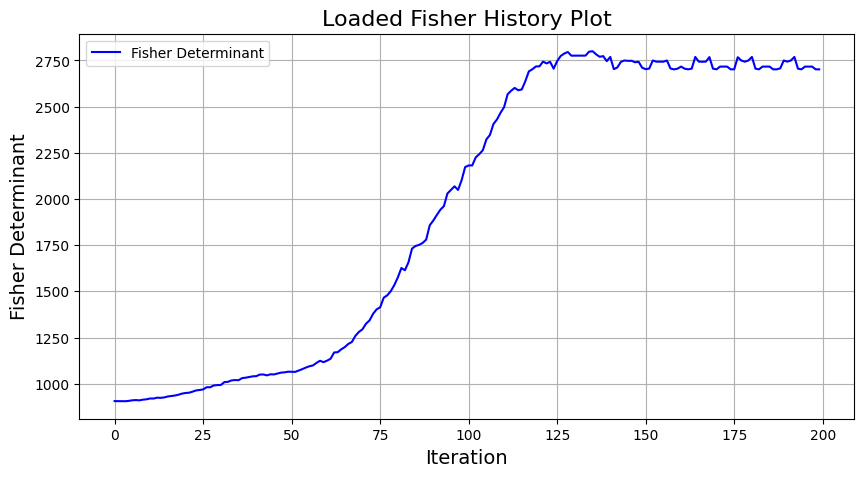

In [33]:
# Load data
iterations = []
fisher_values = []

with open(filename3_fi, "r") as file:
    for line in file:
        data = line.strip().split()  # Split by space
        if len(data) == 2:  # Ensure there are two values (iteration, fisher_value)
            iter_idx, fisher_value = int(data[0]), float(data[1])
            iterations.append(iter_idx)
            fisher_values.append(fisher_value)

# Convert to NumPy array (optional, for easier handling)
iterations = np.array(iterations)
fisher_values = np.array(fisher_values)

# Plot the loaded data
plt.figure(figsize=(10,5))
plt.plot(iterations, fisher_values, color='blue', label="Fisher Determinant")
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Fisher Determinant", fontsize=14)
plt.title("Loaded Fisher History Plot", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()


### Plot 3 datasets

In [39]:
CFI_10 = f"C:/Users/tvle2/Documents/Code/Bosonic/dataset/fisher_history_10_new.txt"
CFI_11 = f"C:/Users/tvle2/Documents/Code/Bosonic/dataset/fisher_history_11_new.txt"
CFI_12 = f"C:/Users/tvle2/Documents/Code/Bosonic/dataset/fisher_history_12_new.txt"

#####################################
iterations_10 = []
fisher_values_10 = []

with open(CFI_10, "r") as file:
    for line in file:
        data = line.strip().split()  # Split by space
        if len(data) == 2:  # Ensure there are two values (iteration, fisher_value)
            iter_idx, fisher_value = int(data[0]), float(data[1])
            iterations_10.append(iter_idx)
            fisher_values_10.append(fisher_value)

# Convert to NumPy array (optional, for easier handling)
iterations_10 = np.array(iterations_10)
fisher_values_10 = np.array(fisher_values_10)

####################################
iterations_11 = []
fisher_values_11 = []

with open(CFI_11, "r") as file:
    for line in file:
        data = line.strip().split()  # Split by space
        if len(data) == 2:  # Ensure there are two values (iteration, fisher_value)
            iter_idx, fisher_value = int(data[0]), float(data[1])
            iterations_11.append(iter_idx)
            fisher_values_11.append(fisher_value)

# Convert to NumPy array (optional, for easier handling)
iterations_11 = np.array(iterations_11)
fisher_values_11 = np.array(fisher_values_11)

####################################
iterations_12 = []
fisher_values_12 = []

with open(CFI_12, "r") as file:
    for line in file:
        data = line.strip().split()  # Split by space
        if len(data) == 2:  # Ensure there are two values (iteration, fisher_value)
            iter_idx, fisher_value = int(data[0]), float(data[1])
            iterations_12.append(iter_idx)
            fisher_values_12.append(fisher_value)

# Convert to NumPy array (optional, for easier handling)
iterations_12 = np.array(iterations_12)
fisher_values_12 = np.array(fisher_values_12)



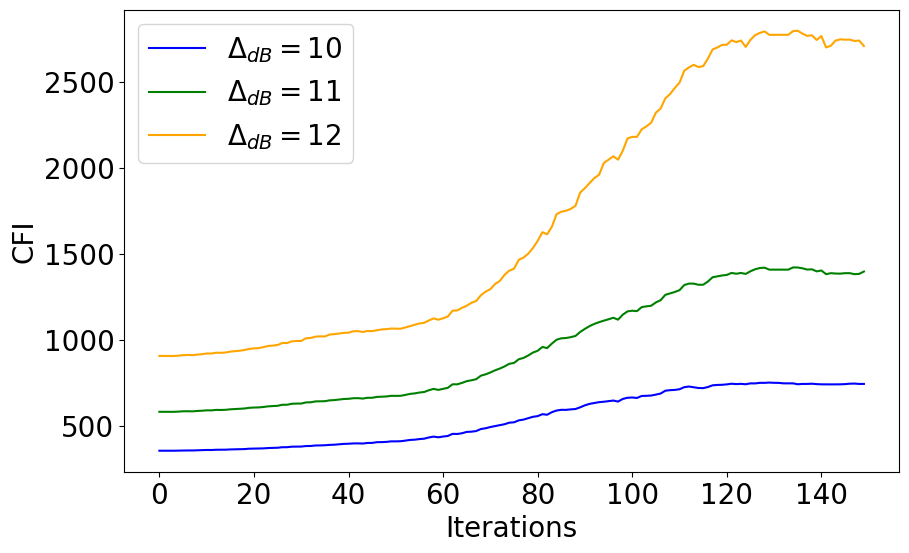

In [41]:
def load_fisher_data(filepath):
    iterations = []
    fisher_values = []
    with open(filepath, "r") as file:
        for line in file:
            data = line.strip().split()  # Split by space
            if len(data) == 2:  # Ensure there are two values (iteration, fisher_value)
                iter_idx, fisher_value = int(data[0]), float(data[1])
                iterations.append(iter_idx)
                fisher_values.append(fisher_value)
    return np.array(iterations), np.array(fisher_values)


# Load the data
iterations_10, fisher_values_10 = load_fisher_data(CFI_10)
iterations_11, fisher_values_11 = load_fisher_data(CFI_11)
iterations_12, fisher_values_12 = load_fisher_data(CFI_12)


max_index = 150
iterations_10, fisher_values_10 = iterations_10[:max_index], fisher_values_10[:max_index]
iterations_11, fisher_values_11 = iterations_11[:max_index], fisher_values_11[:max_index]
iterations_12, fisher_values_12 = iterations_12[:max_index], fisher_values_12[:max_index]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(iterations_10, fisher_values_10,color='blue', label=r"$\Delta_{dB} = 10$")
plt.plot(iterations_11, fisher_values_11,color='green', label=r"$\Delta_{dB} = 11$")
plt.plot(iterations_12, fisher_values_12,color='orange', label=r"$\Delta_{dB} = 12$")


# Optionally increase tick sizes (recommended for clarity)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Iterations", fontsize=20)
plt.ylabel("CFI", fontsize=20)
# plt.title("Comparison of Fisher Values Over Iterations")
plt.legend(fontsize=20)
# plt.grid(True)
plt.savefig('CFI_compare.png', dpi=800)
plt.show()


In [17]:
import strawberryfields as sf
import numpy as np

# Configuration
sf.hbar = 1
epsilon = 0.1  # Squeezing parameter targeting ~10 photons

def check_gkp_photon_number(epsilon):
    """Verify the average photon number of a GKP state with given epsilon."""
    # Create program with single mode
    prog = sf.Program(1)
    
    # Initialize GKP state
    with prog.context as q:
        sf.ops.GKP(state=[0,0], epsilon=epsilon) | q[0]
    
    # Run simulation with bosonic backend
    eng = sf.Engine("bosonic")
    state = eng.run(prog).state
    
    # Calculate average photon number - extract just the mean from the tuple
    mean_and_var = state.mean_photon(0)
    avg_photon = mean_and_var[0]  # Extract just the mean value
    
    # Print results
    print(f"GKP state with epsilon = {epsilon:.4f}")
    print(f"Average photon number: {avg_photon:.2f}")

    return avg_photon

# Run verification
check_gkp_photon_number(epsilon)


GKP state with epsilon = 0.1000
Average photon number: 4.49


array(4.48707468)